<a href="https://colab.research.google.com/github/MayurJadhav123/DiabetesPrediction/blob/main/RiverForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PPI Product Cross Sell**

**by Mayur Jadhav**

#Problem Statement

A consumer bank with a range of products would like to cross-sell insurance to its consumer base (that is, cross-sell the personal protection insurance (PPI) product to those customers who have a secured or unsecured type of loan, but no PPI product as yet). Attached is a sample data set from their customer portfolio containing various fields about their product ownership, credit standing, outstanding amounts, and whether they already have an insurance product (called as PPI / personal protection insurance), if any, the type of PPI product they own. The bank would like to adopt analytics driven approach applied on this sample data for deciding:

Who should they target from the pool of customers that currently do not have a PPI, and

What type of PPI product they should be targeting them with..


**Import Important Packages**

In [1]:
import pandas as pd, numpy as np, pprint, sklearn
import scipy.stats.stats as stats
import plotly.express as px
import networkx as nx
import collections
import pandas as pd, numpy as np, pprint, sklearn
import scipy.stats.stats as stats
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

**Data Preprocessing**

In [2]:
data = pd.read_csv('/content/drive/MyDrive/RiverForest/Dataset.csv')
data.head()

,Ref,Credit_Score,Final_Grade,Term,Net_Advance,APR,Loan_Type,Mosaic,Mosaic_Class,Time_at_Address,...,CIFAS_detected,Time_since_most_recent_outstandi,Insurance_Description,PPI,code,prdt_desc,category,PPI_SINGLE,PPI_JOINT,PPI_LCI
0,1.0,918.0,A,36.0,3000.0,14.4,UnSecured,46.0,8.0,132.0,...,N,16.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0
1,3.0,903.0,A,120.0,21000.0,7.9,secured,16.0,3.0,288.0,...,N,99.0,Life & Critical Illn,1.0,748.0,LIFE & CRITICAL ILLNESS,LCI,0.0,0.0,1.0
2,4.0,1060.0,X,78.0,7200.0,7.9,secured,17.0,3.0,276.0,...,N,50.0,Joint,1.0,719.0,LASCI JOINT,Joint,0.0,1.0,0.0
3,6.0,839.0,B,60.0,8000.0,16.9,UnSecured,47.0,8.0,48.0,...,N,99.0,Life & Critical Illn,1.0,748.0,LIFE & CRITICAL ILLNESS,LCI,0.0,0.0,1.0
4,7.0,1057.0,X,60.0,7650.0,7.4,UnSecured,55.0,10.0,156.0,...,N,99.0,Single,1.0,718.0,LASCI,Single,1.0,0.0,0.0


In [3]:
print(f'Shape of the dataframe: {data.shape}')

Shape of the dataframe: (16386, 59)


In [4]:
#To check the data how it is distributed in terms of data types viz., categorical and numerical
t = data.dtypes.reset_index()
t['Type'] = np.where(t.loc[:, 0].astype(str).isin(['int64', 'float64']), 'Numerical', 'Categorical')
t.groupby('Type').size()
#From above there are 23 columns are categorical and 36 are numerical

Type
Categorical    23
Numerical      36
dtype: int64

**Descriptive Statistics**

In [5]:
data.describe()

,Ref,Credit_Score,Term,Net_Advance,APR,Mosaic,Mosaic_Class,Time_at_Address,Number_of_Dependants,Time_in_Employment,...,Years_on_ER_for_SP,Total___outstanding_CCJ_s,Total_outstanding_balance___excl,Total___of_accounts,Time_since_most_recent_outstandi,PPI,code,PPI_SINGLE,PPI_JOINT,PPI_LCI
count,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,...,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,9405.000000,16383.000000,16383.000000,16383.000000
mean,21168.695294,882.061832,59.142892,7364.007758,18.754587,29.419703,5.352683,120.488128,0.808460,103.096075,...,6.572667,0.157602,137.793628,5.984679,91.697308,0.577489,743.303243,0.382348,0.074773,0.120369
std,12142.797527,93.149605,26.689123,6673.343595,9.662504,16.718957,5.130278,109.192185,1.118947,91.541972,...,7.449055,0.540908,145.935978,2.669217,22.092297,0.493974,24.283753,0.485976,0.263032,0.325402
min,1.000000,352.000000,6.000000,500.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,517.000000,0.000000,0.000000,0.000000
25%,10699.000000,818.000000,48.000000,3000.000000,9.900000,16.000000,3.000000,38.000000,0.000000,38.000000,...,1.000000,0.000000,34.000000,4.000000,99.000000,0.000000,716.000000,0.000000,0.000000,0.000000
50%,21303.000000,882.000000,60.000000,5300.000000,16.900000,25.000000,4.000000,84.000000,0.000000,72.000000,...,4.000000,0.000000,93.000000,6.000000,99.000000,1.000000,756.000000,0.000000,0.000000,0.000000
75%,31689.000000,947.000000,60.000000,9000.000000,24.900000,44.000000,8.000000,180.000000,1.000000,144.000000,...,10.000000,0.000000,194.000000,9.000000,99.000000,1.000000,759.000000,1.000000,0.000000,0.000000
max,42072.000000,1295.000000,300.000000,75000.000000,50.400000,99.000000,99.000000,864.000000,30.000000,600.000000,...,34.000000,9.000000,999.000000,9.000000,99.000000,1.000000,779.000000,1.000000,1.000000,1.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16386 entries, 0 to 16385
Data columns (total 59 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ref                               16383 non-null  float64
 1   Credit_Score                      16383 non-null  float64
 2   Final_Grade                       16383 non-null  object 
 3   Term                              16383 non-null  float64
 4   Net_Advance                       16383 non-null  float64
 5   APR                               16383 non-null  float64
 6   Loan_Type                         16383 non-null  object 
 7   Mosaic                            16383 non-null  float64
 8   Mosaic_Class                      16383 non-null  float64
 9   Time_at_Address                   16383 non-null  float64
 10  Residential_Status                16383 non-null  object 
 11  Telephone_Indicator               16383 non-null  object 
 12  Numb

In [7]:
#Handling Duplicates
data.drop_duplicates()
#Removed 2 duplicate rows from dataset to learn data

,Ref,Credit_Score,Final_Grade,Term,Net_Advance,APR,Loan_Type,Mosaic,Mosaic_Class,Time_at_Address,...,CIFAS_detected,Time_since_most_recent_outstandi,Insurance_Description,PPI,code,prdt_desc,category,PPI_SINGLE,PPI_JOINT,PPI_LCI
0,1.0,918.0,A,36.0,3000.0,14.4,UnSecured,46.0,8.0,132.0,...,N,16.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0
1,3.0,903.0,A,120.0,21000.0,7.9,secured,16.0,3.0,288.0,...,N,99.0,Life & Critical Illn,1.0,748.0,LIFE & CRITICAL ILLNESS,LCI,0.0,0.0,1.0
2,4.0,1060.0,X,78.0,7200.0,7.9,secured,17.0,3.0,276.0,...,N,50.0,Joint,1.0,719.0,LASCI JOINT,Joint,0.0,1.0,0.0
3,6.0,839.0,B,60.0,8000.0,16.9,UnSecured,47.0,8.0,48.0,...,N,99.0,Life & Critical Illn,1.0,748.0,LIFE & CRITICAL ILLNESS,LCI,0.0,0.0,1.0
4,7.0,1057.0,X,60.0,7650.0,7.4,UnSecured,55.0,10.0,156.0,...,N,99.0,Single,1.0,718.0,LASCI,Single,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,42068.0,922.0,A,60.0,7500.0,7.9,UnSecured,55.0,10.0,1.0,...,N,99.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0
16380,42069.0,831.0,C,60.0,1000.0,25.9,UnSecured,12.0,2.0,47.0,...,N,99.0,LASU,1.0,758.0,LASU,Single,1.0,0.0,0.0
16381,42070.0,790.0,D,36.0,3000.0,25.9,UnSecured,9.0,2.0,130.0,...,N,99.0,LASU,1.0,758.0,LASU,Single,1.0,0.0,0.0
16382,42072.0,905.0,A,60.0,8460.0,7.9,UnSecured,44.0,8.0,180.0,...,N,99.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0


In [8]:
cat_var = [key for key in dict(data.dtypes)
            if dict(data.dtypes)[key] in ['object']]
cat_var

['Final_Grade',
 'Loan_Type',
 'Residential_Status',
 'Telephone_Indicator',
 'Marital_Status',
 'Gender',
 'Employment_Status',
 'Full_Part_Time_Empl_Ind',
 'Perm_Temp_Empl_Ind',
 'Current_Account',
 'ACCESS_Card',
 'VISA_Card',
 'American_Express',
 'Diners_Card',
 'Cheque_Guarantee',
 'Other_Credit_Store_Card',
 'Value_of_Property',
 'Payment_Method',
 'Bankruptcy_Detected__SP_',
 'CIFAS_detected',
 'Insurance_Description',
 'prdt_desc',
 'category']

In [9]:
numeric_var = [key for key in dict(data.dtypes)
                   if dict(data.dtypes)[key]
                       in ['float64','float32','int32','int64']] # Numeric Variable
numeric_var


['Ref',
 'Credit_Score',
 'Term',
 'Net_Advance',
 'APR',
 'Mosaic',
 'Mosaic_Class',
 'Time_at_Address',
 'Number_of_Dependants',
 'Time_in_Employment',
 'Income_Range',
 'Time_with_Bank',
 'Outstanding_Mortgage_Bal',
 'Total_Outstanding_Balances',
 'Bureau_Data___Monthly_Other_Co_R',
 'Worst_History_CT',
 'Age',
 'Total_outstanding_balance__mortg',
 'Total___Public_Info___CCJ____ban',
 'Total_value__Public_Info___CCJ__',
 'Time_since_most_recent_Public_In',
 'Total_value__CAIS_8_9s',
 'Worst_status_L6m',
 'Worst_CUrrent_Status',
 '__of_status_3_s_L6m',
 'Searches___Total___L6m',
 'Years_on_ER_for_SP',
 'Total___outstanding_CCJ_s',
 'Total_outstanding_balance___excl',
 'Total___of_accounts',
 'Time_since_most_recent_outstandi',
 'PPI',
 'code',
 'PPI_SINGLE',
 'PPI_JOINT',
 'PPI_LCI']

In [10]:
df = data.drop(['Final_Grade',
 'Loan_Type',
 'Residential_Status',
 'Telephone_Indicator',
 'Marital_Status',
 'Gender',
 'Employment_Status',
 'Full_Part_Time_Empl_Ind',
 'Perm_Temp_Empl_Ind',
 'Current_Account',
 'ACCESS_Card',
 'VISA_Card',
 'American_Express',
 'Diners_Card',
 'Cheque_Guarantee',
 'Other_Credit_Store_Card',
 'Value_of_Property',
 'Payment_Method',
 'Bankruptcy_Detected__SP_',
 'CIFAS_detected',
 'Insurance_Description',
 'prdt_desc',
 'category'],axis=1)

In [11]:
df

,Ref,Credit_Score,Term,Net_Advance,APR,Mosaic,Mosaic_Class,Time_at_Address,Number_of_Dependants,Time_in_Employment,...,Years_on_ER_for_SP,Total___outstanding_CCJ_s,Total_outstanding_balance___excl,Total___of_accounts,Time_since_most_recent_outstandi,PPI,code,PPI_SINGLE,PPI_JOINT,PPI_LCI
0,1.0,918.0,36.0,3000.0,14.4,46.0,8.0,132.0,0.0,288.0,...,10.0,1.0,18.0,6.0,16.0,0.0,NaN,0.0,0.0,0.0
1,3.0,903.0,120.0,21000.0,7.9,16.0,3.0,288.0,0.0,37.0,...,22.0,0.0,203.0,8.0,99.0,1.0,748.0,0.0,0.0,1.0
2,4.0,1060.0,78.0,7200.0,7.9,17.0,3.0,276.0,0.0,154.0,...,21.0,1.0,87.0,7.0,50.0,1.0,719.0,0.0,1.0,0.0
3,6.0,839.0,60.0,8000.0,16.9,47.0,8.0,48.0,0.0,82.0,...,0.0,0.0,229.0,9.0,99.0,1.0,748.0,0.0,0.0,1.0
4,7.0,1057.0,60.0,7650.0,7.4,55.0,10.0,156.0,2.0,342.0,...,13.0,0.0,38.0,6.0,99.0,1.0,718.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16381,42070.0,790.0,36.0,3000.0,25.9,9.0,2.0,130.0,0.0,36.0,...,9.0,0.0,421.0,9.0,99.0,1.0,758.0,1.0,0.0,0.0
16382,42072.0,905.0,60.0,8460.0,7.9,44.0,8.0,180.0,0.0,3.0,...,14.0,0.0,229.0,7.0,99.0,0.0,NaN,0.0,0.0,0.0
16383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#We will first of all check all the missing value Percentage for each of the column
features_with_na = [features for features in data.columns if data[features].isnull().sum()>1]
# Print the % of missing values in each feature
for feature in features_with_na:
    print(feature, np.round(data[feature].isnull().mean(),4),'%missing values')

Ref 0.0002 %missing values
Credit_Score 0.0002 %missing values
Final_Grade 0.0002 %missing values
Term 0.0002 %missing values
Net_Advance 0.0002 %missing values
APR 0.0002 %missing values
Loan_Type 0.0002 %missing values
Mosaic 0.0002 %missing values
Mosaic_Class 0.0002 %missing values
Time_at_Address 0.0002 %missing values
Residential_Status 0.0002 %missing values
Telephone_Indicator 0.0002 %missing values
Number_of_Dependants 0.0002 %missing values
Marital_Status 0.0002 %missing values
Gender 0.0002 %missing values
Time_in_Employment 0.0002 %missing values
Employment_Status 0.0002 %missing values
Full_Part_Time_Empl_Ind 0.0002 %missing values
Perm_Temp_Empl_Ind 0.0002 %missing values
Income_Range 0.0002 %missing values
Current_Account 0.0002 %missing values
ACCESS_Card 0.0002 %missing values
VISA_Card 0.0002 %missing values
American_Express 0.0002 %missing values
Diners_Card 0.0002 %missing values
Cheque_Guarantee 0.0002 %missing values
Other_Credit_Store_Card 0.0002 %missing values


**Checking the Data Distribution thorugh Skewness coefficient**

In [13]:
data.skew()

Ref                                 -0.018320
Credit_Score                        -0.067622
Term                                 1.528258
Net_Advance                          2.716203
APR                                  0.876640
Mosaic                               0.095440
Mosaic_Class                        12.634894
Time_at_Address                      1.393236
Number_of_Dependants                 2.350160
Time_in_Employment                   1.501870
Income_Range                        -0.906416
Time_with_Bank                       0.629384
Outstanding_Mortgage_Bal             7.632483
Total_Outstanding_Balances           3.253459
Bureau_Data___Monthly_Other_Co_R     2.226704
Worst_History_CT                    -0.192889
Age                                  0.192405
Total_outstanding_balance__mortg     2.621400
Total___Public_Info___CCJ____ban     4.304993
Total_value__Public_Info___CCJ__    19.609514
Time_since_most_recent_Public_In    -2.550109
Total_value__CAIS_8_9s            

**All the positive values of skewness for the features are considered the mean is greater than mean. The mean overestimates the values in positively skewed distribution such as**

*25 variables with Highly Skewed Distribution: ['Term', 'Net_Advance', 'Mosaic_Class', 'Time_at_Address', 'Number_of_Dependants', 'Time_in_Employment', 'Value_of_Property', 'Outstanding_Mortgage_Bal', 'Total_Outstanding_Balances', 'Bureau_Data___Monthly_Other_Co_R', 'Total_outstanding_balance__mortg', 'Total___Public_Info___CCJ____ban', 'Total_value__Public_Info___CCJ__', 'Time_since_most_recent_Public_In', 'Total_value__CAIS_8_9s', 'Worst_status_L6m', 'Worst_CUrrent_Status', '__of_status_3_s_L6m', 'Years_on_ER_for_SP', 'Total___outstanding_CCJ_s', 'Total_outstanding_balance___excl', 'Time_since_most_recent_outstandi', 'code', 'PPI_JOINT', 'PPI_LCI']*



*4 variables with Moderately Skewed Distribution: ['APR', 'Income_Range', 'Time_with_Bank', 'Searches___Total___L6m']*

**Reason: Because its value is nearest to zero**

*10 negative minimum valued variables: ['Ref',
 'Credit_Score', 'Time_in_Employment',
 'Income_Range', 'Worst_History_CT',
 'Time_since_most_recent_Public_In',
 'Total___of_accounts',
 'Time_since_most_recent_outstandi',
 'PPI',
 'code',]*






**Visualization Plots**
1.Histplot: Measures of skewness and the histogram shows the data distribution of numerical variables 

2.Boxplot: Boxplot clearly shows the visualization of the outliers for certain features such as 

*'Ref',
 'Credit_Score',
 'Term',
 'Net_Advance',
 'Time_at_Address',
 'Number_of_Dependants',
 'Time_in_Employment',
 'Time_with_Bank',
 'Outstanding_Mortgage_Bal',
 'Total_Outstanding_Balances',
 'Bureau_Data___Monthly_Other_Co_R',
 'Total_outstanding_balance__mortg',
 'Total___Public_Info___CCJ____ban',
 'PPI',
 'code',
 'PPI_SINGLE',
 'PPI_JOINT',
 'PPI_LCI'*



<Figure size 432x288 with 0 Axes>

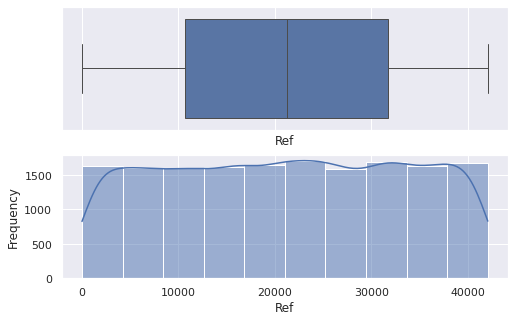

<Figure size 576x360 with 0 Axes>

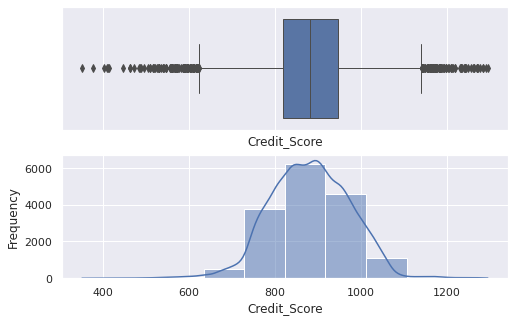

<Figure size 576x360 with 0 Axes>

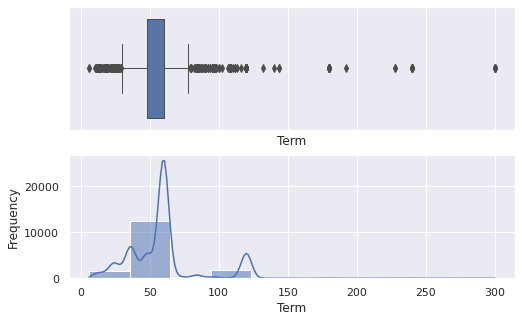

<Figure size 576x360 with 0 Axes>

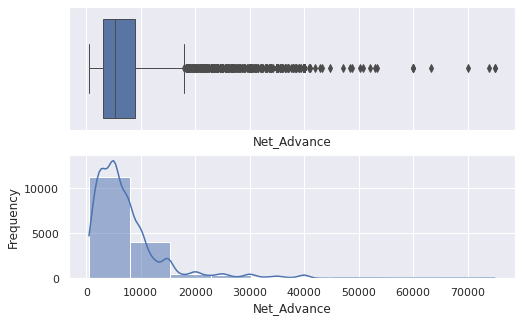

<Figure size 576x360 with 0 Axes>

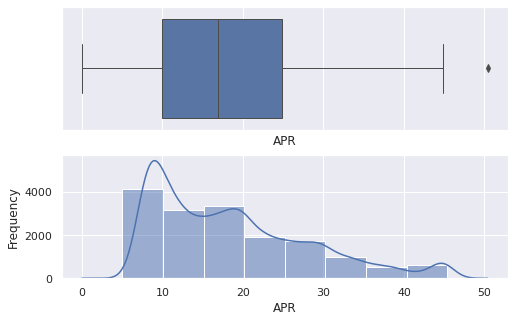

<Figure size 576x360 with 0 Axes>

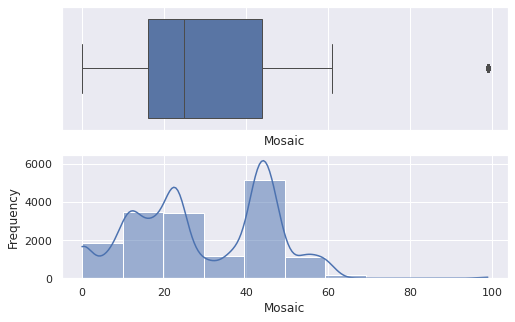

<Figure size 576x360 with 0 Axes>

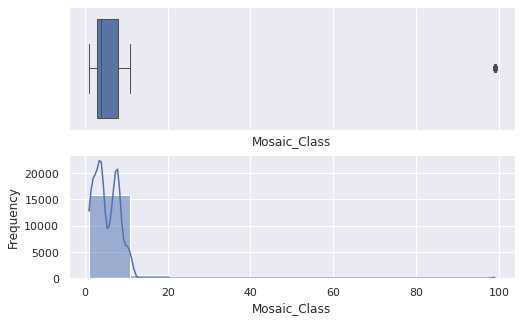

<Figure size 576x360 with 0 Axes>

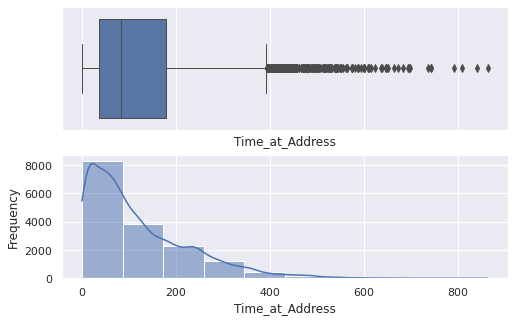

<Figure size 576x360 with 0 Axes>

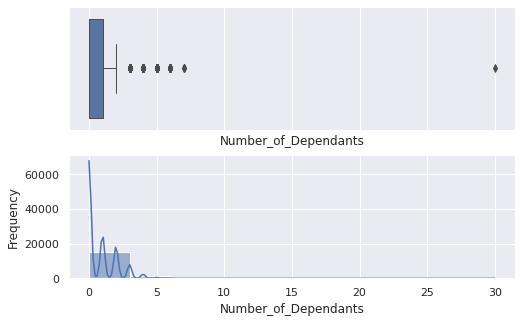

<Figure size 576x360 with 0 Axes>

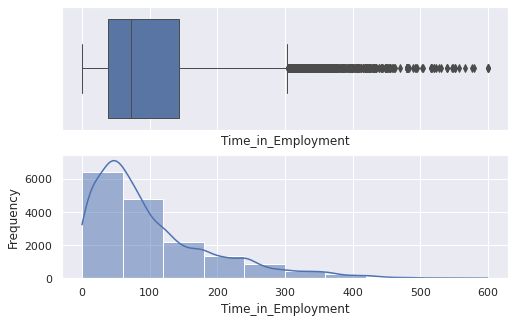

<Figure size 576x360 with 0 Axes>

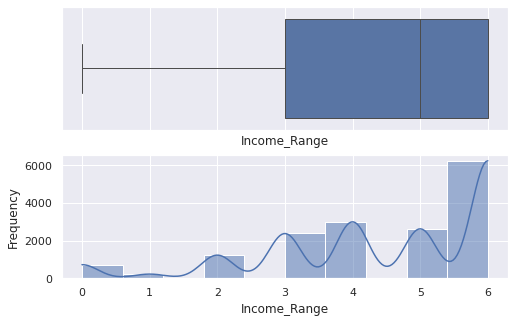

<Figure size 576x360 with 0 Axes>

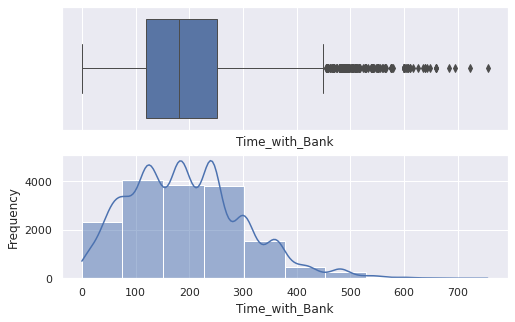

<Figure size 576x360 with 0 Axes>

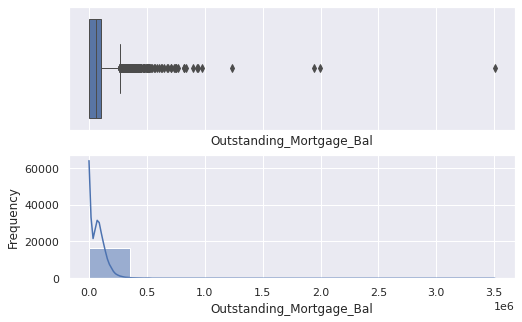

<Figure size 576x360 with 0 Axes>

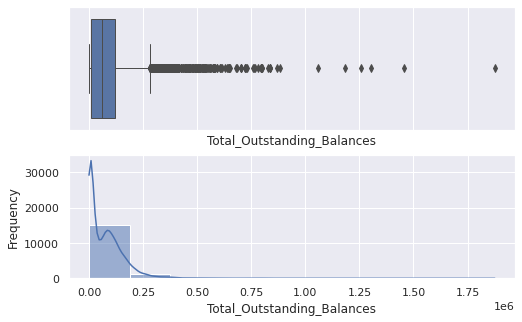

<Figure size 576x360 with 0 Axes>

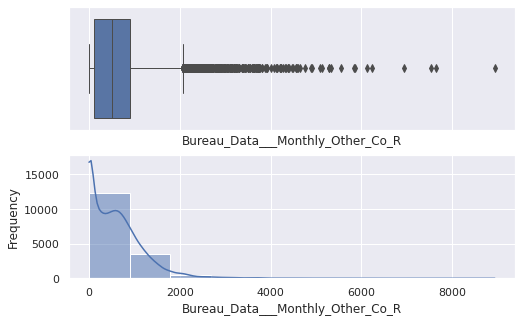

<Figure size 576x360 with 0 Axes>

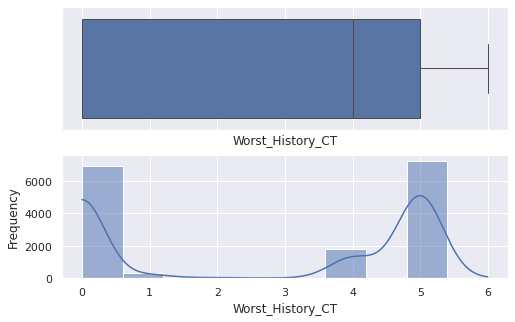

<Figure size 576x360 with 0 Axes>

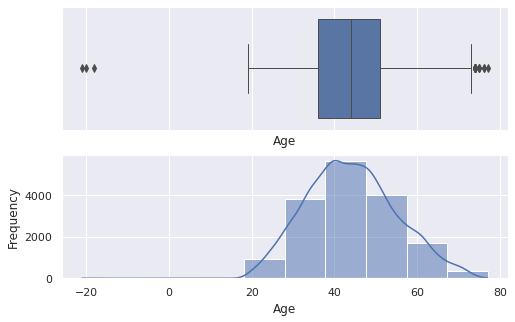

<Figure size 576x360 with 0 Axes>

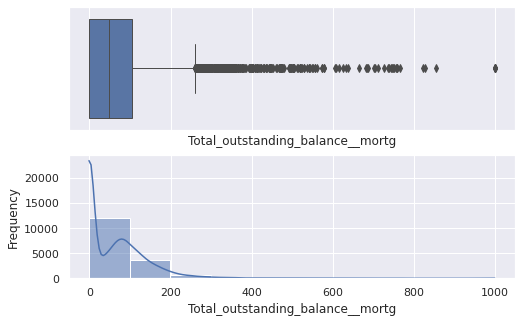

<Figure size 576x360 with 0 Axes>

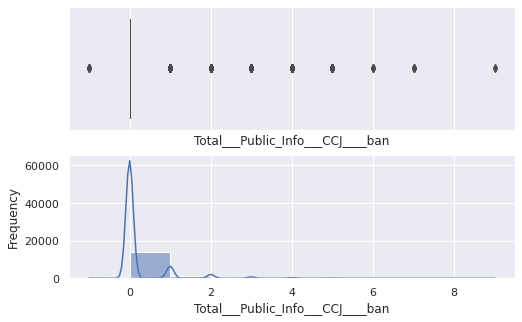

<Figure size 576x360 with 0 Axes>

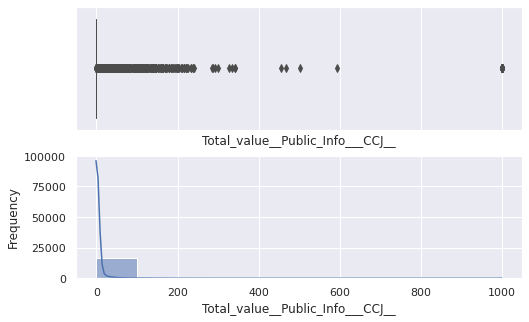

<Figure size 576x360 with 0 Axes>

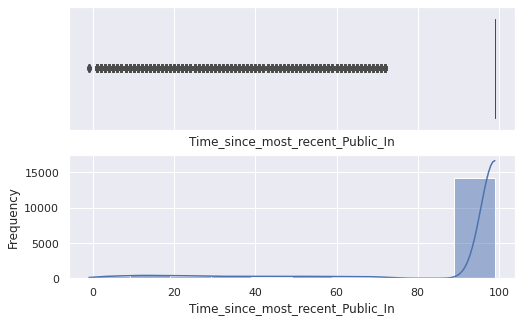

<Figure size 576x360 with 0 Axes>

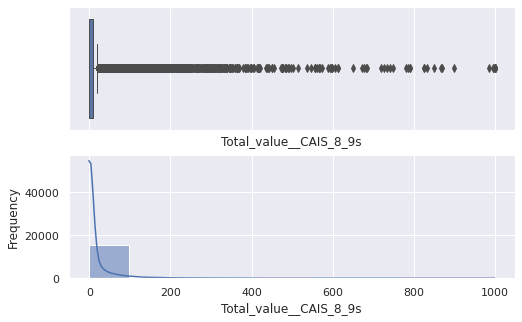

<Figure size 576x360 with 0 Axes>

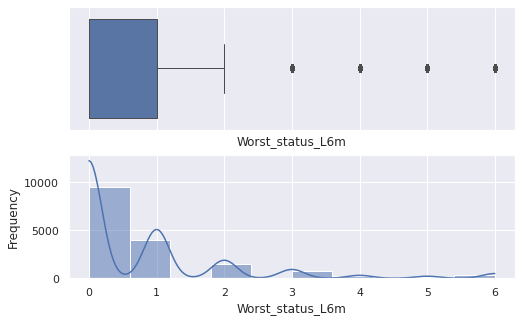

<Figure size 576x360 with 0 Axes>

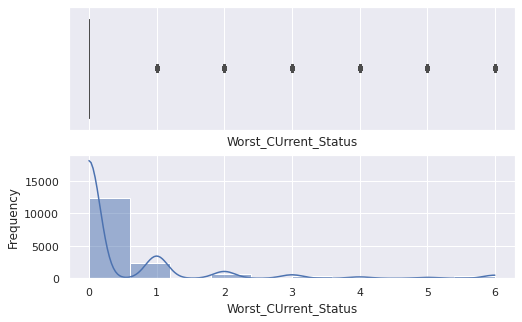

<Figure size 576x360 with 0 Axes>

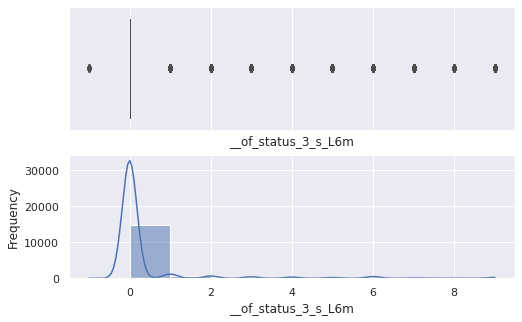

<Figure size 576x360 with 0 Axes>

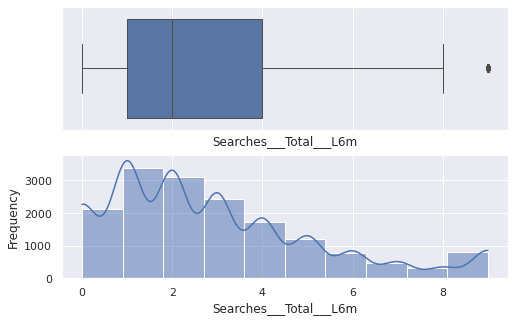

<Figure size 576x360 with 0 Axes>

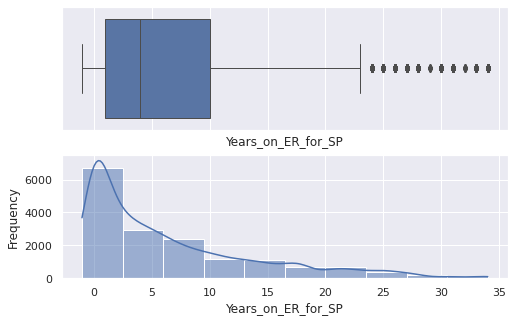

<Figure size 576x360 with 0 Axes>

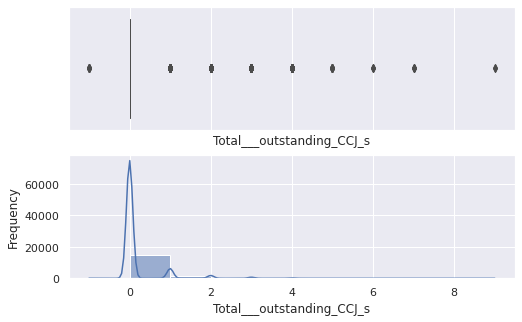

<Figure size 576x360 with 0 Axes>

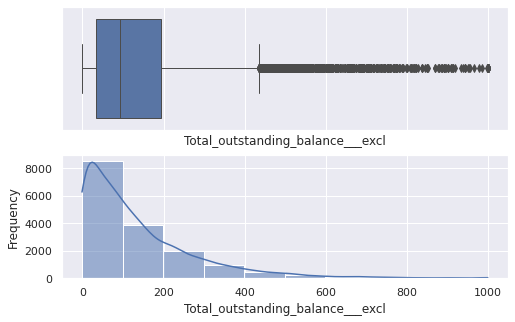

<Figure size 576x360 with 0 Axes>

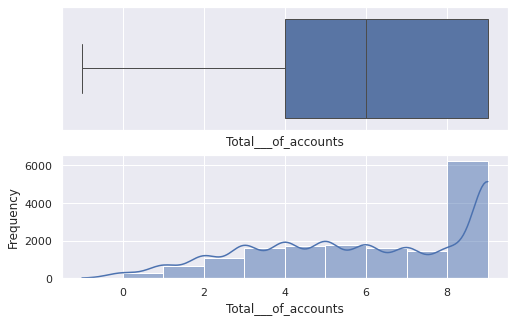

<Figure size 576x360 with 0 Axes>

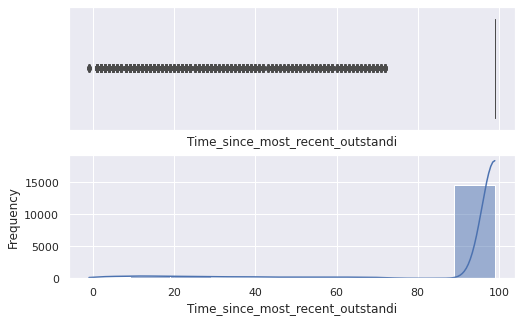

<Figure size 576x360 with 0 Axes>

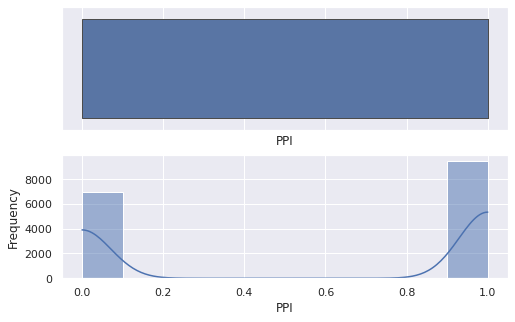

<Figure size 576x360 with 0 Axes>

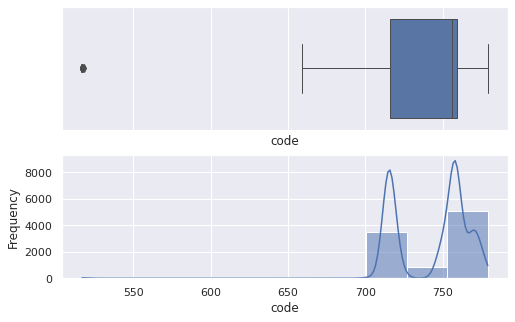

<Figure size 576x360 with 0 Axes>

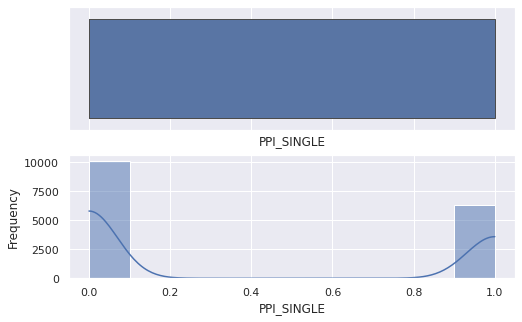

<Figure size 576x360 with 0 Axes>

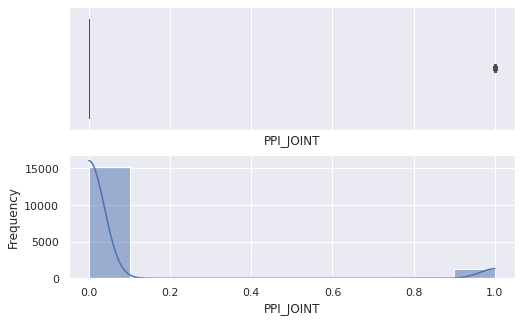

<Figure size 576x360 with 0 Axes>

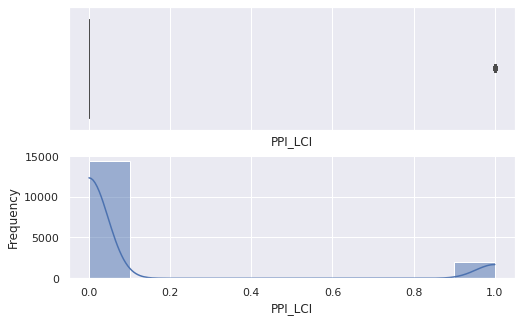

In [14]:
#Plotting the boxplot & Histplot, Boxplot gives the idea of outliers in terms of visualization plot
for i in df.columns:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency')
    sns.boxplot(df[i], ax=ax_box , linewidth= 1.0)
    sns.histplot(df[i], ax=ax_hist , bins = 10,kde=True)
    plt.show()

**Analysis of Categorical Varibles**

In [15]:
c = data.describe(include = ['object']).T.sort_values(by = 'unique')

display(c)

## 12 features have 2 unique values, 3feaures have 3 unique values, 2features have 4 unique values
## and remaining had 5, 9, 10, 15 and 24 unique values

,count,unique,top,freq
VISA_Card,16383,2,TRUE,12087
Loan_Type,16383,2,UnSecured,13054
Telephone_Indicator,16383,2,Y,15241
Gender,16383,2,M,9770
Full_Part_Time_Empl_Ind,16383,2,F,16308
Perm_Temp_Empl_Ind,16383,2,P,16361
Current_Account,16383,2,TRUE,16351
ACCESS_Card,16383,2,FALSE,13028
Other_Credit_Store_Card,16383,2,FALSE,12976
American_Express,16383,2,FALSE,16227


In [16]:
print('Unique values in categorical variables...')
display(c.reset_index().groupby('unique').size())

Unique values in categorical variables...


unique
2      12
3       3
4       3
9       1
10      1
15      1
24      1
655     1
dtype: int64

#Checking the data whether balanced or imbalanced for feature PPI

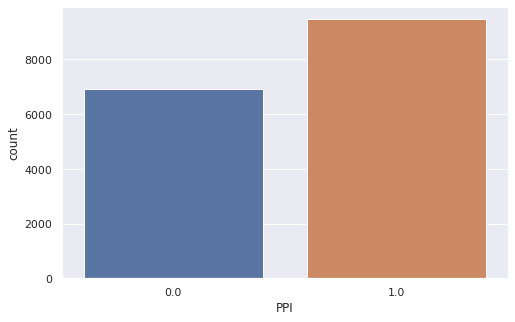

In [17]:
#Checking the data whether balanced or imbalanced
# diabetes countplot
sns.countplot(x = 'PPI',data = data)
# Hold_PPI = 1, don't_hold_PPI = 0
# Data consist of Hold_PPI = 42.3% , don't_hold_PPI = 57.7% So the data is nearly balanced

**Exploratoty Data Analysis**

In [18]:
print('About 42 percent of the customer don\'t hold a PPI product and is our target population.')
_ = data.groupby('PPI').size().to_frame('counts').reset_index()
_['PPI'].replace({0: 'Don\'t Hold PPI', 1: 'Hold PPI'}, inplace = True)
fig = px.pie(_, values = 'counts', names = 'PPI', color = 'PPI', height = 400, width = 500,
             #title = 'Distribution of PPI (Holding vs Non-holding Customers)', 
             color_discrete_map = {'Don\'t Hold PPI': '#F2B705', 'Hold PPI': '#D9CEC1'})
fig.show()

About 42 percent of the customer don't hold a PPI product and is our target population.


In [19]:
print('Identify columns with missing values in the dataframe and propotion of missing values')
pd.DataFrame([(data.isnull().sum()[data.isnull().sum()>0]),
              (data.isnull().sum()[data.isnull().sum()>0]/len(data))], 
             index = ['Missing No', 'Missing Proportion']).T

Identify columns with missing values in the dataframe and propotion of missing values


,Missing No,Missing Proportion
Ref,3.0,0.000183
Credit_Score,3.0,0.000183
Final_Grade,3.0,0.000183
Term,3.0,0.000183
Net_Advance,3.0,0.000183
APR,3.0,0.000183
Loan_Type,3.0,0.000183
Mosaic,3.0,0.000183
Mosaic_Class,3.0,0.000183
Time_at_Address,3.0,0.000183


In [20]:
## fill missing values for columns "Insurance_Description","category","prdt_desc" with "Missing" for categorical column and -1 for numerical column
misCatCols = ['Insurance_Description', 'category', 'prdt_desc']
data[misCatCols] = data[misCatCols].fillna('Missing')
data['code'] = data['code'].fillna(-1)

In [21]:
## Replace "JOINT" with "Joint" in "category" column
print('Replaced "JOINT" with "Joint" in the category column')
data['category'] = data['category'].replace('JOINT', 'Joint')
_ = data.groupby('category').size().to_frame('counts').reset_index()
fig = px.pie(_, values = 'counts', names = 'category', color = 'category', 
             title = 'Distribution of values in category variable', height = 600, width = 500,
             color_discrete_map = {'Missing': '#B9FFFC', 'Single': '#A3D8F4', 'LCI': '#9AB3F5', 'Joint': '#7579E7'})
fig.show()

Replaced "JOINT" with "Joint" in the category column


In [22]:
## "Insurance_Description" standardization
data['Insurance_Description'] = data['Insurance_Description'].str.strip().replace({
                                'LIFE & CRITICAL ILLN': 'Life & Critical Illn',
                                'Life & CI': 'Life & Critical Illn',
                                'JOINT LIFE & CRITICA': 'Joint Life & Critica',
                                '1st Cust - LASCI / 2': '1st Cust LASCI / 2nd',
                                '1st Cust-LASCI /2nd': '1st Cust LASCI / 2nd',
                                '1st Cust - LASU / 2n' : '1st Cust LASU / 2nd',
                                '1st Cust-LASU/ 2nd C': '1st Cust LASU / 2nd'}) 

In [23]:
print('Almost similar columns: "category", "Insurance_Description", "prdt_desc"')
display(data.groupby(['category', 'Insurance_Description', 'prdt_desc']).size())

Almost similar columns: "category", "Insurance_Description", "prdt_desc"


category  Insurance_Description  prdt_desc                         
Joint     1st Cust LASCI / 2nd   1st Cust LASCI / 2nd Cust LASU          10
          1st Cust LASU / 2nd    1st Cust LASU / 2nd Cust LASCI           8
          JOINT LASCI            JOINT LASCI                             39
          JOINT LASU             JOINT LASU                             159
          Joint                  1st Cust - LASCI / 2nd Cust - LASU      52
                                 1st Cust - LASU / 2nd Cust - LASCI      44
                                 1st Cust LASCI / 2nd Cust LASU          17
                                 1st Cust LASU / 2nd Cust LASCI          10
                                 JOINT LASCI                             26
                                 JOINT LASU                             113
                                 LASCI JOINT                            123
                                 LASU JOINT                             604
          Other     

In [24]:
## Looking at "category" and "Insurance_Description"
_ = (data.groupby(['category', 'Insurance_Description']).size()
     .sort_values(ascending = False).to_frame('count').reset_index())
fig = px.bar(_, x = 'category', y = 'count', color = 'Insurance_Description', 
             height = 600, width = 500, title = 'Category & Insurance Description Analysis')
fig.update_layout(template = 'simple_white')
fig.show()

In [25]:
#Analyzing Bankruptcy_Detected_SP variable
display(data['Bankruptcy_Detected__SP_'].value_counts().sort_values(ascending = False),
        data['CIFAS_detected'].value_counts().sort_values(ascending = False))

N    16351
Y       24
T        8
Name: Bankruptcy_Detected__SP_, dtype: int64

N    16292
Y       83
T        8
Name: CIFAS_detected, dtype: int64

In [26]:
## Analyzing "Bankruptcy_Detected__SP_" & "CIFAS_detected"
print("For most customers, bankruptcy was not detected")
print('However, for some bankruptcy wasn\'t detected but CIFAS was detected.')
print('I will not be considering customers with either Bankruptcy or CIFAS detected for cross-sell of PPI products.')
print('Also since I\'am not sure of what is "T" here I will drop that as well from the target population.')
print('Target population is customers currently not having a PPI product.')
data.groupby(['Bankruptcy_Detected__SP_','CIFAS_detected']).size()

##Keeping only the one who without bankruptcy and CIFAS
data['Check'] = 'Drop'
data.loc[(data['Bankruptcy_Detected__SP_'] == 'N')&
         (data['CIFAS_detected'] == 'N') &
         (data['PPI'] == 0),'Check'] = 'Keep'
data.loc[(data['PPI'] == 1), 'Check'] = 'Keep'

For most customers, bankruptcy was not detected
However, for some bankruptcy wasn't detected but CIFAS was detected.
I will not be considering customers with either Bankruptcy or CIFAS detected for cross-sell of PPI products.
Also since I'am not sure of what is "T" here I will drop that as well from the target population.
Target population is customers currently not having a PPI product.


In [27]:
print('Number of customers with either a bankruptcy or a CIFAS detected (Y & T):', 
      data.loc[data['Check']=='Drop'].shape[0])
data = data.loc[(data['Check']=='Keep')]
print('Shape of dataframe after dropping customers with either a bankruptcy or a CIFAS detected (Y & T):', data.shape)
del data['Check']

Number of customers with either a bankruptcy or a CIFAS detected (Y & T): 40
Shape of dataframe after dropping customers with either a bankruptcy or a CIFAS detected (Y & T): (16346, 60)


In [28]:
## Checking unique values in categorical columns - Spell correct and space removal needed
cat_cols = data.select_dtypes(include = 'object').columns

for col in cat_cols:
    print('{} column unique values: {}'.format(col, list(data[col].unique())))

## Removing spaces and spell correction in categorical columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.str.strip().replace('FALS', 'FALSE'))

Final_Grade column unique values: ['A', 'X', 'B', 'D', 'E', 'C', 'R', 'F', 'O', 'S']
Loan_Type column unique values: ['UnSecured', 'secured  ']
Residential_Status column unique values: ['H', 'R', 'T', 'L']
Telephone_Indicator column unique values: ['Y', 'N']
Marital_Status column unique values: ['M', 'S', 'D', 'W']
Gender column unique values: ['M', 'F']
Employment_Status column unique values: ['S', 'R', 'P', 'G', 'D', 'M', 'H', 'U', 'T']
Full_Part_Time_Empl_Ind column unique values: ['F', 'P']
Perm_Temp_Empl_Ind column unique values: ['P', 'T']
Current_Account column unique values: ['TRUE', 'FALS']
ACCESS_Card column unique values: ['FALSE', 'TRUE ']
VISA_Card column unique values: ['FALSE', 'TRUE ']
American_Express column unique values: ['FALSE', 'TRUE ']
Diners_Card column unique values: ['FALSE', 'TRUE ']
Cheque_Guarantee column unique values: ['TRUE', 'FALS']
Other_Credit_Store_Card column unique values: ['TRUE  ', 'FALSE ']
Value_of_Property column unique values: ['1,78,000.00',

In [29]:
## Handle high cardinality - leaving apart the 'Insurance_Description' and 'prdt_desc'
# Reference: https://medium.com/analytics-vidhya/how-handle-high-cardinality-d889ca61b6a6
print('Considering all below 5% in proportion as "Others" provided that the column has more than 3 values')
cardCols = list(data.select_dtypes(include='object').columns)
# cardCols.remove('Insurance_Description')
cardCols.remove('prdt_desc')

for col in cardCols:
    counts = data[col].value_counts(normalize=True)
    if (len(counts)) > 3:
        l = list(counts.loc[counts<0.05].index)
        data.loc[data[col].isin(l), col] = 'Others'
        print(f'{col} - List of values replaced as "Others":', l)
        _ = data.groupby(col).size().sort_values(ascending = False).to_frame('count').reset_index()
        fig = px.bar(_, x = col, y = 'count', color = col, height = 600, width = 500, 
                     title = 'Plot of Values in {}'.format(col))
        fig.update_layout(template = 'simple_white')
        fig.show()

Considering all below 5% in proportion as "Others" provided that the column has more than 3 values
Final_Grade - List of values replaced as "Others": ['F', 'O', 'R', 'S']


Residential_Status - List of values replaced as "Others": ['L', 'R']


Marital_Status - List of values replaced as "Others": ['W']


Employment_Status - List of values replaced as "Others": ['R', 'D', 'M', 'U', 'H', 'T']


Value_of_Property - List of values replaced as "Others": ['1,50,000.00', '2,00,000.00', '2,50,000.00', '1,30,000.00', '1,00,000.00', '1,80,000.00', '1,40,000.00', '1,60,000.00', '1,10,000.00', '90,000.00', '1,25,000.00', '1,90,000.00', '1,70,000.00', '95,000.00', '1,35,000.00', '2,20,000.00', '80,000.00', '3,00,000.00', '1,65,000.00', '85,000.00', '1,75,000.00', '1,15,000.00', '2,40,000.00', '1,45,000.00', '2,10,000.00', '3,50,000.00', '1,05,000.00', '2,30,000.00', '1,85,000.00', '1,55,000.00', '2,25,000.00', '1,95,000.00', '75,000.00', '2,60,000.00', '2,80,000.00', '70,000.00', '4,00,000.00', '2,70,000.00', '2,35,000.00', '92,000.00', '2,75,000.00', '96,000.00', '89,000.00', '98,000.00', '3,20,000.00', '94,000.00', '60,000.00', '65,000.00', '5,00,000.00', '4,50,000.00', '1,08,000.00', '1,37,000.00', '1,02,000.00', '1,27,000.00', '99,000.00', '1,03,000.00', '1,06,000.00', '1,17,000.00', '2,15,000.00', '87,000.00', '1,28,000.00', '1,29,000.00', '1,14,000.00', '88,000.00', '1,22,000.00',

Insurance_Description - List of values replaced as "Others": ['LASCI', 'Other', 'Joint Life & Critica', '1st Cust LASU / 2nd', 'JOINT LASU', '1st Cust LASCI / 2nd', 'Gold', 'JOINT LASCI', 'Plus', 'Select', 'Bronze', 'Silver', 'Foundation']


category - List of values replaced as "Others": []


In [30]:
print('Final_Grade - A, X and B are contributing most for PPI products being bought by the customers')
_ = data.groupby(['PPI', 'Final_Grade']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Final_Grade', height = 600, width = 500,
            color_discrete_sequence=px.colors.qualitative.Bold)
fig.update_layout(template = 'simple_white')
fig.show()

Final_Grade - A, X and B are contributing most for PPI products being bought by the customers


In [31]:
print('Loan_Type - Customers preference is towards unsecured loans')
_ = data.groupby(['PPI', 'Loan_Type']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Loan_Type', height = 600, width = 500,
            color_discrete_sequence=px.colors.qualitative.Vivid)
fig.update_layout(template = 'simple_white')
fig.show()

Loan_Type - Customers preference is towards unsecured loans


In [32]:
print('Residential_Status - In comparison with customers buying a PPI vs not buying one ...')
pprint.pprint('the percentage of T residential status increases, while H decreases.')
_ = data.groupby(['PPI', 'Residential_Status']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Residential_Status', height = 600, width = 500,
            color_discrete_sequence=px.colors.qualitative.Vivid)
fig.update_layout(template = 'simple_white')
fig.show()

Residential_Status - In comparison with customers buying a PPI vs not buying one ...
'the percentage of T residential status increases, while H decreases.'


In [33]:
print('Telephone_Indicator - People buying PPI or not is weakly affected by whether or not they have a telephone.')
_ = (data.groupby(['PPI', 'Telephone_Indicator']).size()
     .to_frame('count').reset_index()
     .sort_values(by = 'count', ascending = False))
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Telephone_Indicator', height = 600, width = 500,
            color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_layout(template = 'simple_white')
fig.show()
# data['Telephone_Indicator'].replace({'N':0, 'Y': 1}, inplace = True)
# print('Correlation between both the variables')
# display(data[['PPI', 'Telephone_Indicator']].corr())
## 'Telephone_Indicator' variable is dropped from the further analysis
del data['Telephone_Indicator']

Telephone_Indicator - People buying PPI or not is weakly affected by whether or not they have a telephone.


In [34]:
## Assuming D-Divorced, M-Married, S-Single, W-Widowed
print('Marital_Status - Proportion of Married people having a PPI is slightly lower than not having it')
pprint.pprint('whereas proportion of Single, Widowed, and Divorced people prefer having a PPI product.')

_ = data.groupby(['PPI', 'Marital_Status']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Marital_Status', height = 600, width = 500,
            color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_layout(template = 'simple_white')
fig.show()

Marital_Status - Proportion of Married people having a PPI is slightly lower than not having it
('whereas proportion of Single, Widowed, and Divorced people prefer having a '
 'PPI product.')


In [35]:
print('Gender - Percentage of Female total customers having a PPI product is ~2% higher than total Female customers not having it.')
_ =  data.groupby('Gender').size().to_frame('count').reset_index()
fig1 = px.pie(_, names = 'Gender', color = 'Gender', values = 'count', height = 600, width = 500, 
              color_discrete_sequence = px.colors.qualitative.D3)

_1 = data.groupby(['PPI', 'Gender']).size().to_frame('count').reset_index()
fig2 = px.bar(_1, x = 'PPI', y = 'count', color = 'Gender', height = 600, width = 500,
            color_discrete_sequence=px.colors.qualitative.D3)
fig1.update_layout(template = 'simple_white')
fig2.update_layout(template = 'simple_white')
fig1.show()
fig2.show()

Gender - Percentage of Female total customers having a PPI product is ~2% higher than total Female customers not having it.


In [36]:
print('Employment Status - In a total customer with a PPI, the proportion of P increases by ~5%.')
pprint.pprint('The proportion of G makes up about 3% of the decrease in a total customer with a PPI versus not having a PPI.')

_ =  data.groupby('Employment_Status').size().to_frame('count').reset_index()
fig1 = px.pie(_, names = 'Employment_Status', color = 'Employment_Status', values = 'count', height = 600, width = 500, 
              color_discrete_map = {'P': '#716F81', 'G': '#B97A95', 'S': '#F6AE99', 'Others': '#F2E1C1'})

_1 = data.groupby(['PPI', 'Employment_Status']).size().to_frame('count').reset_index()
fig2 = px.bar(_1, x = 'PPI', y = 'count', color = 'Employment_Status', height = 600, width = 500,
            color_discrete_map = {'P': '#716F81', 'G': '#B97A95', 'S': '#F6AE99', 'Others': '#F2E1C1'})
fig1.update_layout(template = 'simple_white')
fig2.update_layout(template = 'simple_white')
fig1.show()
fig2.show()

Employment Status - In a total customer with a PPI, the proportion of P increases by ~5%.
('The proportion of G makes up about 3% of the decrease in a total customer '
 'with a PPI versus not having a PPI.')


In [37]:
print('Full_Part_Time_Empl_Ind - Despite the fact that full-time employees represent a large portion of the data...')
pprint.pprint('they are of little significance when determining whether a PPI product can be targeted to them.')
_ = data.groupby(['PPI', 'Full_Part_Time_Empl_Ind']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Full_Part_Time_Empl_Ind', height = 600, width = 500,
            color_discrete_map = {'F': '#F1ECC3', 'P': '#57837B'})
fig.update_layout(template = 'simple_white')
fig.show()

# data['Full_Part_Time_Empl_Ind'].replace({'F':1, 'P':0}, inplace = True)
# data[['PPI', 'Full_Part_Time_Empl_Ind']].corr()
## dropping the 'Full_Part_Time_Empl_Ind' variable
del data['Full_Part_Time_Empl_Ind']

Full_Part_Time_Empl_Ind - Despite the fact that full-time employees represent a large portion of the data...
('they are of little significance when determining whether a PPI product can '
 'be targeted to them.')


In [38]:
print('Perm_Temp_Empl_Ind - A weaker attribute towards determining...')
pprint.pprint('whether a PPI product can be targetted to people with permanent or temporary employment.')
_ = data.groupby(['PPI', 'Perm_Temp_Empl_Ind']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Perm_Temp_Empl_Ind', height = 600, width = 500,
            color_discrete_map = {'P': '#6E6D6D', 'T': '#FFAA71'})
fig.update_layout(template = 'simple_white')
fig.show()

# data['Perm_Temp_Empl_Ind'].replace({'P':1, 'T': 0}, inplace = True)
# data[['PPI', 'Perm_Temp_Empl_Ind']].corr()
## dropping the 'Full_Part_Time_Empl_Ind' variable
del data['Perm_Temp_Empl_Ind']

Perm_Temp_Empl_Ind - A weaker attribute towards determining...
('whether a PPI product can be targetted to people with permanent or temporary '
 'employment.')


In [39]:
print('Current_Account - An insignificant variable in determining a PPI product to targeted to or not.')
_ = data.groupby(['PPI', 'Current_Account']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Current_Account', height = 600, width = 500,
            color_discrete_map = {'TRUE': '#EEB76B', 'FALSE': '#F1D6AB'})
fig.update_layout(template = 'simple_white')
fig.show()

## Dropping 'Current_Account' variable
del data['Current_Account']

Current_Account - An insignificant variable in determining a PPI product to targeted to or not.


In [40]:
print('VISA_Card - A 1% here and there against customers to be preferred with visa card or not - not that significant.')
_ = data.groupby(['PPI', 'VISA_Card']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'VISA_Card', height = 600, width = 500,
            color_discrete_map = {'FALSE': '#A0C1B8', 'TRUE': '#719FB0'})
fig.update_layout(template = 'simple_white')
fig.show()

## Dropping 'VISA_Card' from the further analysis
del data['VISA_Card']

VISA_Card - A 1% here and there against customers to be preferred with visa card or not - not that significant.


In [41]:
print('American_Express - A ~1% here and there against customers to be preferred with American express card or not.')
_ = data.groupby(['PPI', 'American_Express']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'American_Express', height = 600, width = 500,
            color_discrete_map = {'FALSE': '#6b705c', 'TRUE': '#a5a58d'})
fig.update_layout(template = 'simple_white')
fig.show()

## Dropping 'American_Express' from the further analysis
del data['American_Express']

American_Express - A ~1% here and there against customers to be preferred with American express card or not.


In [42]:

print('Diners_Card - A ~1% here and there against customers to be preferred with diners card or not.')
_ = data.groupby(['PPI', 'Diners_Card']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Diners_Card', height = 600, width = 500,
            color_discrete_map = {'FALSE': '#283618', 'TRUE': '#fefae0'})
fig.update_layout(template = 'simple_white')
fig.show()

## Dropping 'Diners_Card' from the further analysis
del data['Diners_Card']

Diners_Card - A ~1% here and there against customers to be preferred with diners card or not.


In [43]:
print('Cheque_Guarantee - Customers with a PPI hold a cheque guarantee about ~2% higher than the customers without a PPI.')
_ = data.groupby(['PPI', 'Cheque_Guarantee']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Cheque_Guarantee', height = 600, width = 500,
            color_discrete_map = {'FALSE': '#8ecae6', 'TRUE': '#219ebc'})
fig.update_layout(template = 'simple_white')
fig.show()

Cheque_Guarantee - Customers with a PPI hold a cheque guarantee about ~2% higher than the customers without a PPI.


In [44]:
print('Other_Credit_Store_Card - Almost a 2% difference in total number of customers holding other credit card store...')
pprint.pprint('when compared against customers having a PPI product or not having it.')
_ = data.groupby(['PPI', 'Other_Credit_Store_Card']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Other_Credit_Store_Card', height = 600, width = 500,
            color_discrete_map = {'FALSE': '#ffccd5', 'TRUE': '#ff4d6d'})
fig.update_layout(template = 'simple_white')
fig.show()

Other_Credit_Store_Card - Almost a 2% difference in total number of customers holding other credit card store...
'when compared against customers having a PPI product or not having it.'


In [45]:
print('Payment_Method - An insignificant variable in considering a PPI product cross-selling.')
_ = data.groupby(['PPI', 'Payment_Method']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Payment_Method', height = 600, width = 500)
fig.update_layout(template = 'simple_white')
fig.show()

## Dropping 'Payment_Method' variable from further analysis
del data['Payment_Method']

Payment_Method - An insignificant variable in considering a PPI product cross-selling.


In [46]:
print('Bankruptcy_Detected__SP_ - Already played a role in the deciding a targeted population.')
## Dropping 'Bankruptcy_Detected__SP_' from further analysis -
del data['Bankruptcy_Detected__SP_']

Bankruptcy_Detected__SP_ - Already played a role in the deciding a targeted population.


In [47]:
print('CIFAS_detected - Already played a role in deciding target population')
## Dropping 'CIFAS_detected' from the further analysis
del data['CIFAS_detected']

CIFAS_detected - Already played a role in deciding target population


In [48]:
print('Insurance_Description - Missing for all customers part of target population.')
pprint.pprint('For all customers who are having a PPI, insurance description is always available.')
_ = data.groupby(['PPI', 'Insurance_Description']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'Insurance_Description', height = 600, width = 500)
fig.update_layout(template = 'simple_white')
fig.show()

Insurance_Description - Missing for all customers part of target population.
('For all customers who are having a PPI, insurance description is always '
 'available.')


In [49]:
print('prdt_desc - Missing for all customers part of target population.')
pprint.pprint('Customers who are having a PPI, prdt_desc is available for ~98% of them.')
_ = data.groupby(['PPI', 'prdt_desc']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'prdt_desc', height = 600, width = 500)
fig.update_layout(template = 'simple_white')
fig.show()

prdt_desc - Missing for all customers part of target population.
'Customers who are having a PPI, prdt_desc is available for ~98% of them.'


In [50]:
print('category - Missing for all customers part of target population.')
pprint.pprint('For all customers who are having a PPI, category is always available.')
_ = data.groupby(['PPI', 'category']).size().to_frame('count').reset_index()
fig = px.bar(_, x = 'PPI', y = 'count', color = 'category', height = 600, width = 500)
fig.update_layout(template = 'simple_white')
fig.show()

category - Missing for all customers part of target population.
'For all customers who are having a PPI, category is always available.'


In [51]:
print('Category and Insurance Description for customers who have a PPI product and where Product Description is missing')
display(data.loc[(data['PPI'] == 1) & (data['prdt_desc'] == 'Missing')]
        [['category', 'Insurance_Description', 'prdt_desc']].value_counts())

Category and Insurance Description for customers who have a PPI product and where Product Description is missing


category  Insurance_Description  prdt_desc
Single    Others                 Missing      116
dtype: int64

In [52]:
## Replace 'FALSE' with 0 and 'TRUE' with 1
cat_cols = list(data.select_dtypes(include='object').columns)
data[cat_cols] = data[cat_cols].apply(lambda x: x.replace({'FALSE':0, 'TRUE':1}))

In [53]:
from sklearn.preprocessing import LabelEncoder
le = sklearn.preprocessing.LabelEncoder()
encVal = {}
cat_cols = list(data.select_dtypes(include = 'object').columns)
for col in cat_cols:
    print('{} column unique values: {}'.format(col, list(data[col].unique())))
    data[col + '_le'] = le.fit_transform(data[col])
    encVal[col] = list(data[[col, col +'_le']].drop_duplicates().set_index(col + '_le').to_dict().values())[0]
    del data[col]

Final_Grade column unique values: ['A', 'X', 'B', 'D', 'E', 'C', 'Others']
Loan_Type column unique values: ['UnSecured', 'secured']
Residential_Status column unique values: ['H', 'Others', 'T']
Marital_Status column unique values: ['M', 'S', 'D', 'Others']
Gender column unique values: ['M', 'F']
Employment_Status column unique values: ['S', 'Others', 'P', 'G']
Value_of_Property column unique values: ['Others', '1,20,000.00']
Insurance_Description column unique values: ['Missing', 'Life & Critical Illn', 'Joint', 'Single', 'Others', 'LASU']
prdt_desc column unique values: ['Missing', 'LIFE & CRITICAL ILLNESS', 'LASCI JOINT', 'LASCI', 'LASU', 'LASU JOINT', 'JOINT LIFE & CRITICAL ILLNESS', '1st Cust - LASU / 2nd Cust - LCI', '1st Cust - LASU / 2nd Cust - LASCI', '1st Cust - LASCI / 2nd Cust - LCI', '1st Cust - LASCI / 2nd Cust - LASU', '1st Cust - LASU / 2nd Cust - L', 'JOINT LASU', '1st Cust LASU / 2nd Cust LASCI', '1st Cust LASCI / 2nd Cust LASU', 'JOINT LASCI']
category column unique v

**Feature Reduction**

Feature reduction based on the pearson pairwise correlation matrix and then correlation of the variable with the PPI. Where there were multi-colinear features, their correlation with PPI variable was checked and the one with lower correlation was dropped from the analysis.

In [54]:
#Correlation Matrix
def correlation_matrix(df, threshold = 0.8):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (30, 24))
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = cmap, square=True, linewidths = .5, cbar_kws = {'shrink': .5}, annot =True)
    ax.set_title('Correlation Matrix of data')

    #Filter for correlation value greater than threshold
    sort = corr.abs().unstack()
    sort = sort.sort_values(kind = 'quicksort', ascending = False)
    display(sort[(sort > threshold) & (sort < 1)])

In [55]:
#List of Columns
Cols = list(data.select_dtypes(include = np.number).columns)
Cols.remove('PPI')
Cols.remove('Ref')
print('List of columns except Ref and PPI::',Cols)

List of columns except Ref and PPI:: ['Credit_Score', 'Term', 'Net_Advance', 'APR', 'Mosaic', 'Mosaic_Class', 'Time_at_Address', 'Number_of_Dependants', 'Time_in_Employment', 'Income_Range', 'ACCESS_Card', 'Cheque_Guarantee', 'Other_Credit_Store_Card', 'Time_with_Bank', 'Outstanding_Mortgage_Bal', 'Total_Outstanding_Balances', 'Bureau_Data___Monthly_Other_Co_R', 'Worst_History_CT', 'Age', 'Total_outstanding_balance__mortg', 'Total___Public_Info___CCJ____ban', 'Total_value__Public_Info___CCJ__', 'Time_since_most_recent_Public_In', 'Total_value__CAIS_8_9s', 'Worst_status_L6m', 'Worst_CUrrent_Status', '__of_status_3_s_L6m', 'Searches___Total___L6m', 'Years_on_ER_for_SP', 'Total___outstanding_CCJ_s', 'Total_outstanding_balance___excl', 'Total___of_accounts', 'Time_since_most_recent_outstandi', 'code', 'PPI_SINGLE', 'PPI_JOINT', 'PPI_LCI', 'Final_Grade_le', 'Loan_Type_le', 'Residential_Status_le', 'Marital_Status_le', 'Gender_le', 'Employment_Status_le', 'Value_of_Property_le', 'Insurance_D

In [56]:
# Correlation matrix for numerical variables
# correlation_matrix(data[Cols], threshold = 0.7) #threshold = 0.5

In [57]:
## Dropping variables - since these variables are correlated with other variables
## While deciding which variable to drop variable's correlation with 'PPI' was checked
## the one with the lower correlation is dropped
dropCols = ('Total_Outstanding_Balances', 'Time_since_most_recent_outstandi', 
            'Total___outstanding_CCJ_s', 'Bureau_Data___Monthly_Other_Co_R', 
            'Total___Public_Info___CCJ____ban', 'Net_Advance', 'Years_on_ER_for_SP',
            'Outstanding_Mortgage_Bal', '__of_status_3_s_L6m', 'Worst_CUrrent_Status',
            'Mosaic_Class', 'APR', 'category_le')
Cols = [e for e in Cols if e not in dropCols]

Residential_Status_le  Value_of_Property_le     0.863803
Value_of_Property_le   Residential_Status_le    0.863803
dtype: float64

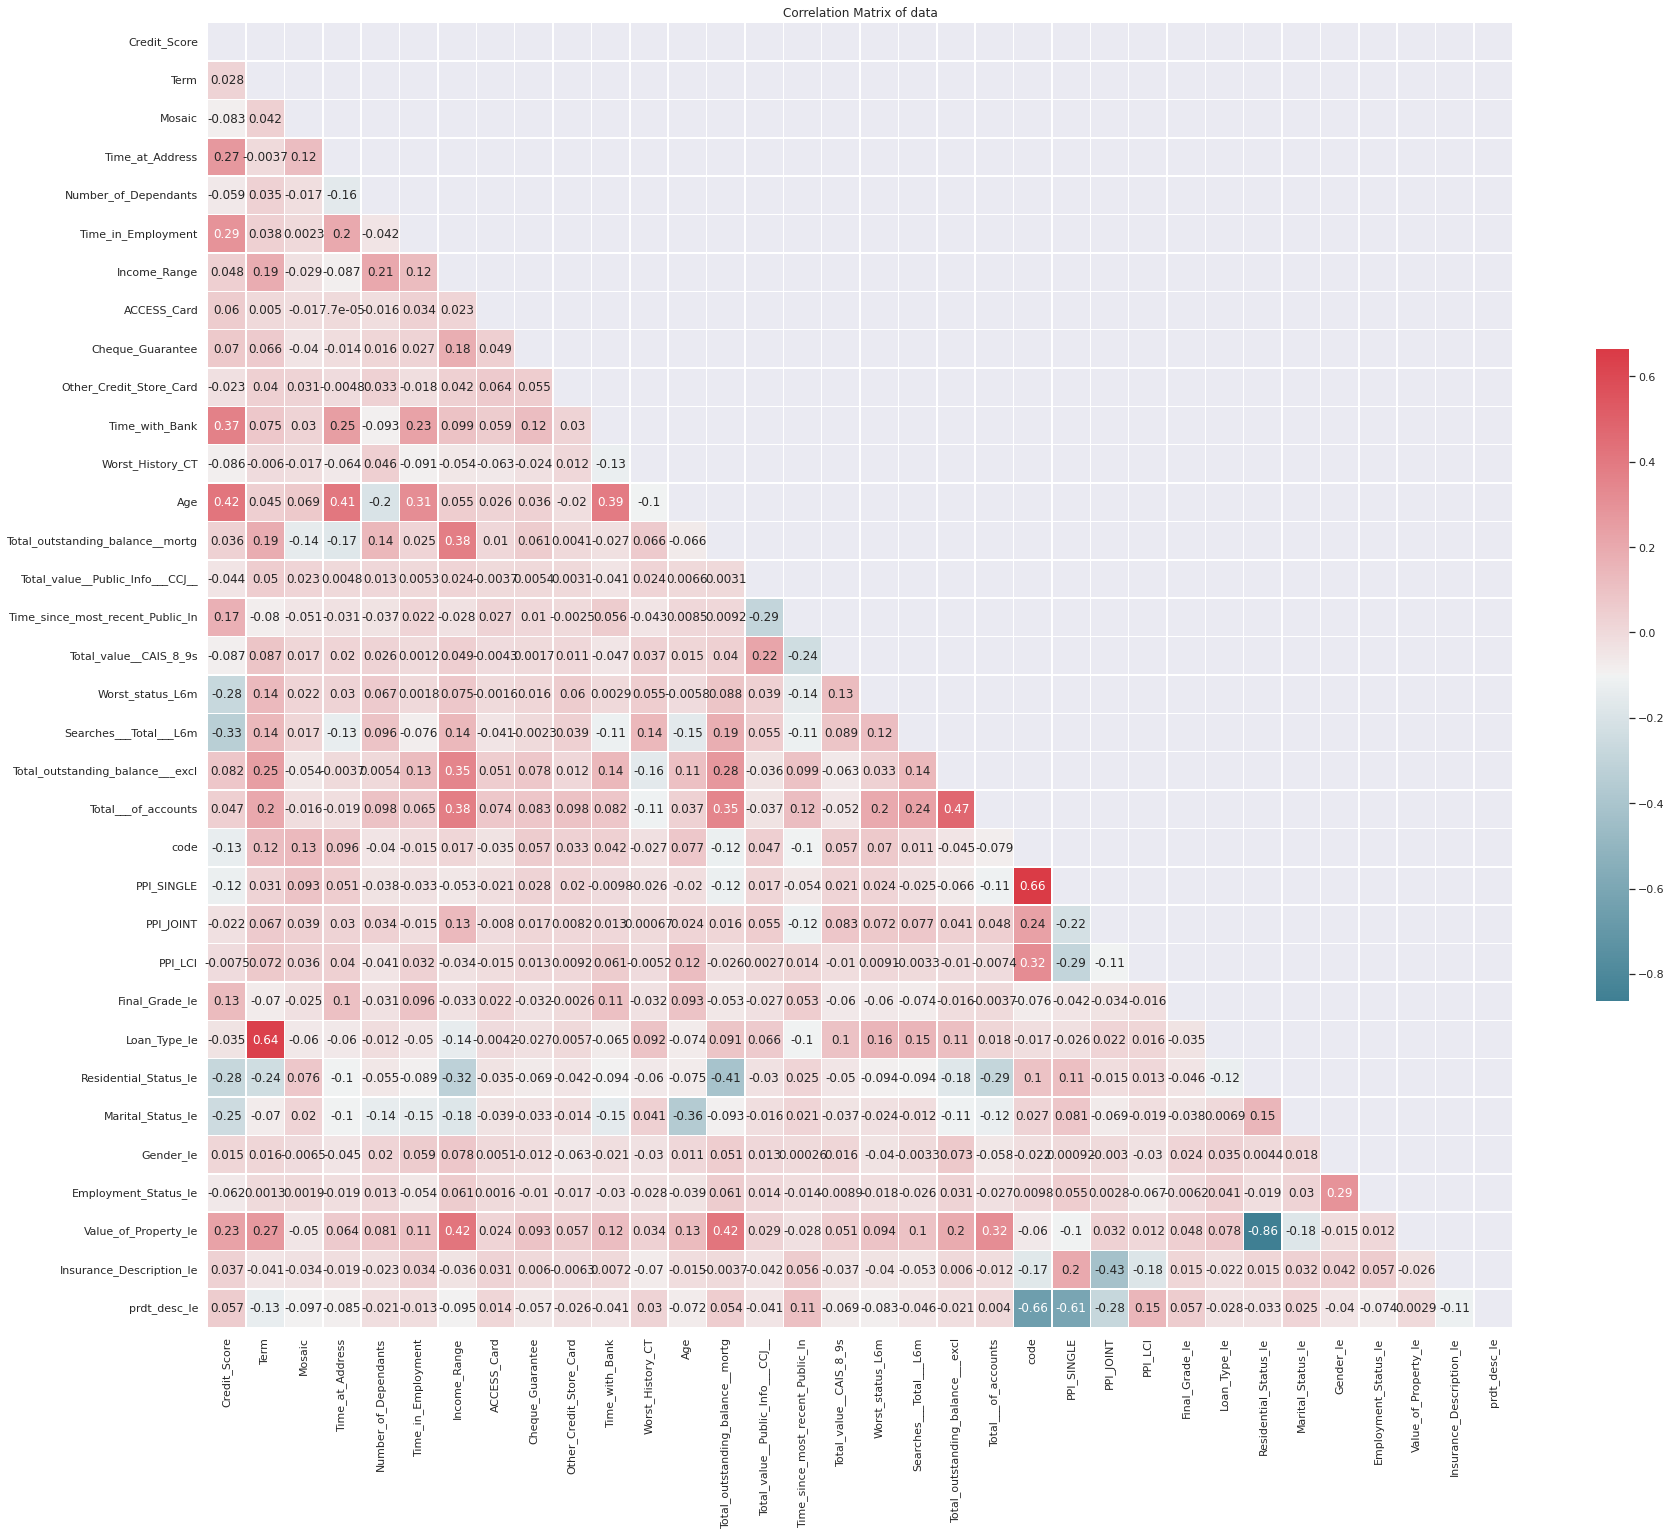

In [58]:
#Correlation Matrix for numerical Variables
correlation_matrix(data[Cols], threshold = 0.7)

In [59]:
#Absolute correlation of independent variables (numerical) with target variable
absCorrWithDep = []
for var in Cols:
    absCorrWithDep.append(abs(data['PPI'].corr(data[var])))
display(pd.DataFrame([Cols, absCorrWithDep], index = ['Variable','Correlation']).T.sort_values('Correlation',ascending = False).reset_index(drop=True).head())

,Variable,Correlation
0,code,0.991764
1,PPI_SINGLE,0.672413
2,prdt_desc_le,0.64947
3,PPI_LCI,0.315972
4,PPI_JOINT,0.242807


In [60]:
#Consider the important columns
Cols.extend(['PPI','Ref'])
data = data[Cols]

**Feature Selection**

In [61]:
##for any negative value in the dataset, replace with median 
## Assuming negative velues has not meaning in the dataset
l = []
for c in list(data.columns):
    try:
        if c != 'code' and min(data[c]) < 0:
            l.append(c)
            data.loc[data[c] < 0, c] = data[c].median()
    except:
          pass
print('List of Columns containing negative values, except code variable, include:', l)

List of Columns containing negative values, except code variable, include: ['Age', 'Total_outstanding_balance__mortg', 'Total_value__Public_Info___CCJ__', 'Time_since_most_recent_Public_In', 'Total_value__CAIS_8_9s', 'Total_outstanding_balance___excl', 'Total___of_accounts']


In [62]:
def prep_dataset(data, target):
    from xverse.feature_subset import SplitXY
    clf = SplitXY([target])  #Split dataset into X and y
    X, y = clf.fit_transform(data)
    #returns features (X) dataset and target y as a numpy array
    return X, y

In [63]:
from xverse.transformer import WOE
## Adding interpretation to IV
def interpretation(iv):
    if iv < 0.02:
        return 'useless'
    elif iv >= 0.02 and iv < 0.1:
        return 'weak'
    elif iv >= 0.1 and iv < 0.3:
        return 'medium'
    elif iv >= 0.3 and iv < 0:
        return 'strong'
    else:
        return 'Suspicious'

## Prepare dataset - as required by the package 
X, y = prep_dataset(data, target = 'PPI')

#Calculate WOE and IV for columns of the data dataframe 
clf  = WOE(mono_max_bins=30)

##fit WOE
clf.fit(X, y)

##get clf transformed woe dataframe 
# woedf =  clf.transform(X)

## IV dataframe
IV = clf.iv_df
IV['Interpretation'] = IV['Information_Value'].map(interpretation)
display(IV)

,Variable_Name,Information_Value,Interpretation
34,prdt_desc_le,0.899262,Suspicious
16,PPI_SINGLE,0.718341,Suspicious
33,code,0.439489,Suspicious
8,Insurance_Description_le,0.239598,medium
11,Mosaic,0.093838,weak
28,Total_value__CAIS_8_9s,0.077963,weak
20,Term,0.075806,weak
3,Credit_Score,0.067078,weak
18,Residential_Status_le,0.055238,weak
27,Total_outstanding_balance__mortg,0.053702,weak


In [64]:
print('Based on the IV - Which are the strong, medium, weak attributes?')
ivSelCols = (list(IV.loc[IV['Interpretation'].isin(['strong', 'medium', 'weak']), 'Variable_Name']))
print(ivSelCols)

Based on the IV - Which are the strong, medium, weak attributes?
['Insurance_Description_le', 'Mosaic', 'Total_value__CAIS_8_9s', 'Term', 'Credit_Score', 'Residential_Status_le', 'Total_outstanding_balance__mortg', 'Total_value__Public_Info___CCJ__', 'PPI_LCI', 'Total___of_accounts', 'Final_Grade_le', 'Time_at_Address', 'Value_of_Property_le', 'Income_Range', 'Age', 'Marital_Status_le']


In [65]:
print('Considering only the suspicious, strong, medium, and weak variables based on the IV')
ivSelCols.extend(['PPI', 'Ref', 'Insurance_Description_le'])

data = data.loc[:, list(set(ivSelCols))]

print('Shape of the data after selecting featurers based on the Information Value:', data.shape)

Considering only the suspicious, strong, medium, and weak variables based on the IV
Shape of the data after selecting featurers based on the Information Value: (16346, 18)


In [66]:
## Correlation of independent variables with PPI
corr = data.corrwith(data['PPI']).sort_values().drop('PPI')
fig = px.bar(corr, color_discrete_map = {'Variable': 'red'},
             labels={'value': 'Correlation',
                     'index': 'Variable'},
             title = 'Correlation of Independent with Dependent Variables')
fig.update_traces(hovertemplate = 'Variable: %{x} Correlation: %{y}')
fig.update_layout(showlegend = False, template = 'simple_white')
fig.show()

**Exploratory Data Analysis - Numerical Columns**

In [67]:
## Getting the updated list of categorical columns and numerical columns
catCols = data.columns[data.columns.str.contains('_le', case=True)]
numCols = list(set(data.columns) - set(catCols))
numCols.remove('PPI')
numCols.remove('Ref')

In [68]:
## Get back the categorical value columns
for k, v in encVal.items():
    try: data[k] = data[k + '_le'].replace(v)
    except: pass

In [69]:
_ =  data.groupby('Income_Range').size().to_frame('count').reset_index()
_['Percentage'] = np.round(_['count']/_['count'].sum(), 3)
_.sort_values(by = 'Percentage', ascending = False, inplace = True)
fig = px.bar(_, x = 'Income_Range', color = 'Income_Range', text = _['Percentage'],
             y = 'count', height = 500, width = 800)
fig.update_layout(template = 'simple_white', 
                  title = 'Income range = 6 accounted for 38% of all the income range available')
fig.show()

In [70]:
print('Income_Range - Customers at lower and higher income range don\'t prefer PPI products.')
_ = data.groupby(['PPI','Income_Range']).size().reset_index()
_['Percentage'] = (data.groupby(['PPI', 'Income_Range']).size()
                          .groupby(level = 0).apply(lambda x:100 * x / float(x.sum())).values)
_.columns = ['PPI', 'Income_Range', 'Counts', 'Percentage']
_['Percentage'] = _['Percentage'].map('{:,.2f}%'.format)

fig = px.bar(_, x = 'PPI', y = 'Counts', color = 'Income_Range', 
             barmode = 'stack', text = _['Percentage'], color_continuous_scale = 'teal')
fig.update_layout(title = 'Ideal income range for PPI is [1-5]', template = 'simple_white',
                  xaxis_title = 'PPI', yaxis_title = 'Counts', width = 600, height = 600)
fig.show()

Income_Range - Customers at lower and higher income range don't prefer PPI products.


In [71]:
_ =  data.groupby('Total___of_accounts').size().to_frame('count').reset_index()
_['Percentage'] = np.round(_['count']/_['count'].sum()*100, 2)
_.sort_values(by = 'Percentage', ascending = False, inplace = True)
fig = px.bar(_, x = 'Total___of_accounts', color = 'Total___of_accounts', text = _['Percentage'],
             y = 'count', height = 500, width = 800)
fig.update_layout(template = 'simple_white', 
                  title = 'Customers with 9 number of accounts accounted for a whopping 30% of all customers')
fig.show()

In [72]:
print('Total___of_accounts - Contains negative number !!! Replacing negative with the median')
data.loc[data['Total___of_accounts'] < 0, 'Total___of_accounts'] = data['Total___of_accounts'].median()

print('Analysis of total number of accounts by PPI')
_ = data.groupby(['PPI','Total___of_accounts']).size().reset_index()
_['Percentage'] = (data.groupby(['PPI', 'Total___of_accounts']).size()
                          .groupby(level = 0).apply(lambda x:100 * x / float(x.sum())).values)
_.columns = ['PPI', 'Total___of_accounts', 'Counts', 'Percentage']
_['Percentage'] = _['Percentage'].map('{:,.2f}%'.format)

fig = px.bar(_, x = 'PPI', y = 'Counts', color = 'Total___of_accounts', 
             barmode = 'stack', text = _['Percentage'], color_continuous_scale = 'purp')
fig.update_layout(title = 'Ideal number of accounts range for PPI is [1-6]', template = 'simple_white',
                  xaxis_title = 'PPI', yaxis_title = 'Counts', width = 600, height = 600)
fig.show()

Total___of_accounts - Contains negative number !!! Replacing negative with the median
Analysis of total number of accounts by PPI


In [73]:
print('Analysis of Total of Accounts, Insurance Description and PPI based on Average Number of Accounts')
fig = px.histogram(data, y = 'Insurance_Description', x = 'Total___of_accounts', color = 'PPI', histfunc = 'avg',
                  color_discrete_sequence = px.colors.qualitative.Dark24)
fig.update_layout(title = 'Average of total accounts for customers holding PPI was highest in Joint insurance product', 
                  template = 'simple_white', xaxis_title = 'category', yaxis_title = 'Count of Total___of_accounts', 
                  width = 800, height = 500)
fig.show()

Analysis of Total of Accounts, Insurance Description and PPI based on Average Number of Accounts


In [74]:
print('Analysis of Total of Accounts, Category and PPI based on counts')
fig = px.histogram(data, x = 'Insurance_Description', y = 'Total___of_accounts', 
                   color = 'Total___of_accounts', histfunc = 'count', facet_col = 'PPI')
fig.update_layout(title = 'Customers with total of accounts = 9 are to be preferred for offering PPI', 
                  template = 'simple_white', xaxis_title = 'Insurance_Description', yaxis_title = 'Count of Total___of_accounts', 
                  width = 800, height = 600)
fig.show()

Analysis of Total of Accounts, Category and PPI based on counts


In [75]:
print('Age - Contains negative number !!! Replacing negative with the median')
data.loc[data['Age'] < 0, 'Age'] = data['Age'].median()

## Binning age variable
data['Age_bin'] = pd.qcut(data['Age'], q = 6, precision = 0).apply(lambda x: str(x.left) + '-' + str(x.right))

Age - Contains negative number !!! Replacing negative with the median


In [76]:
## Analysis of Age_bin & PPI
_ = data.groupby(['PPI', 'Age_bin']).size().to_frame('count').reset_index()
_['Percentage'] = (data.groupby(['PPI', 'Age_bin']).size()
                   .groupby(level = 0).apply(lambda x: np.round(100 * x / float(x.sum()), 2)).values)

fig = px.bar(_, x = 'PPI', y = 'count', color = 'Age_bin', barmode = 'group', text = _['Percentage'])
fig.update_traces(texttemplate = '%{text:.2s}', textposition = 'inside')
fig.update_layout(uniformtext_minsize = 8, uniformtext_mode = 'hide', template = 'simple_white', width = 800, height = 500,
title = 'Age group 33-39 & 48-55 hold ~37% of PPI products and age group 18-44 can be targeted the most for selling PPI products',
font = dict(size = 9))
fig.show()

In [77]:
_ = data.groupby(['PPI', 'Mosaic']).size().to_frame('count').reset_index()
_['Percentage'] = (data.groupby(['PPI', 'Mosaic']).size()
                   .groupby(level = 0).apply(lambda x: np.round(100 * x / float(x.sum()), 2)).values)

fig = px.bar(_, x = 'Mosaic', color = 'PPI', y = 'count', height = 500, width = 1000, 
             template = 'simple_white', facet_col = 'PPI', text = _['Percentage'])
fig.update_layout(title = 'Mosaic = 0 account for 8.5% of customers not holding a PPI product')
fig.show()

fig = px.scatter(_, x = 'Mosaic', y = 'count', size = 'count', color = 'PPI', marginal_y = 'violin',
                 marginal_x = 'box', trendline = 'ols', template = 'simple_white')
fig.update_layout(title = 'Analysis of Mosaic & PPI - Outliers exists')
fig.show()

In [78]:
# Binning term variable
data['Term_bin'] = pd.cut(data['Term'], bins = 20, precision = 0).apply(lambda x: str(x.left) + '-' + str(x.right))
_ = data.groupby(['PPI', 'Term_bin']).size().to_frame('count').reset_index()
_['Percentage'] = (data.groupby(['PPI', 'Term_bin']).size()
                   .groupby(level = 0).apply(lambda x: np.round(100 * x / float(x.sum()), 2)).values)

fig = px.bar(_, x = 'PPI', y = 'count', color = 'Term_bin', barmode = 'group', 
             text = _['Percentage'], template = 'simple_white', 
             color_discrete_sequence = px.colors.qualitative.Prism,
             title = 'About 50% of the terms were of 50-65 months irrespective of the PPI flag')
fig.show()

In [79]:
## Binning Total_outstanding_balance__mortg variable and considering -ve balance as 0
data.loc[data['Total_outstanding_balance__mortg'] < 0, 'Total_outstanding_balance__mortg'] = 0
data['Total_outstanding_balance__mortg_bin'] = (pd.cut(data['Total_outstanding_balance__mortg'], 
                                                      bins = 10, precision = 3)
                                                .apply(lambda x: str(x.left) + '-' + str(x.right)))
_ = data.groupby(['PPI', 'Total_outstanding_balance__mortg_bin']).size().to_frame('count').reset_index()
_['Percentage'] = (data.groupby(['PPI', 'Total_outstanding_balance__mortg_bin']).size()
                   .groupby(level = 0).apply(lambda x: np.round(100 * x / float(x.sum()), 2)).values)

fig = px.bar(_, x = 'PPI', y = 'count', color = 'Total_outstanding_balance__mortg_bin', barmode = 'group', 
             text = _['Percentage'], template = 'simple_white', 
             color_discrete_sequence = px.colors.qualitative.Pastel2,
             title = 'Close to 70% of the customers had 0-99 outstanding mortgage balance irrespective of the PPI flag')
fig.show()

In [80]:
## Binning Time_at_Address variable
data['Time_at_Address_bin'] = (pd.cut(data['Time_at_Address'], bins = 10, precision = 0)
                               .apply(lambda x: str(x.left) + '-' + str(x.right)))
_ = data.groupby(['PPI', 'Time_at_Address_bin']).size().to_frame('count').reset_index()
_['Percentage'] = (data.groupby(['PPI', 'Time_at_Address_bin']).size()
                   .groupby(level = 0).apply(lambda x: np.round(100 * x / float(x.sum()), 2)).values)

fig = px.bar(_, x = 'PPI', y = 'count', color = 'Time_at_Address_bin', barmode = 'group', 
     text = _['Percentage'], template = 'simple_white', 
     color_discrete_sequence = px.colors.qualitative.Plotly,
     title = 'Customers staying at the address between 0 and 260 days can be prioritized for cross-selling PPI products')
fig.show()

In [81]:

## Binning Credit_Score variable
data['Credit_Score_bin'] = (pd.cut(data['Credit_Score'], bins = 15, precision = 0)
                               .apply(lambda x: str(x.left) + '-' + str(x.right)))
_ = data.groupby(['PPI', 'Credit_Score_bin']).size().to_frame('count').reset_index()
_['Percentage'] = (data.groupby(['PPI', 'Credit_Score_bin']).size()
                   .groupby(level = 0).apply(lambda x: np.round(100 * x / float(x.sum()), 2)).values)

fig = px.bar(_, x = 'PPI', y = 'count', color = 'Credit_Score_bin', barmode = 'group', 
     text = _['Percentage'], template = 'simple_white', 
     color_discrete_sequence = px.colors.qualitative.Vivid,
     title = 'PPI products are more likely to be sold to customers with a credit score between 792 and 918')
fig.show()

_ = data.groupby(['PPI', 'Credit_Score']).size().to_frame('count').reset_index()
_['Percentage'] = (data.groupby(['PPI', 'Credit_Score']).size()
                   .groupby(level = 0).apply(lambda x: np.round(100 * x / float(x.sum()), 2)).values)

fig = px.scatter(_, x = 'Credit_Score', y = 'count', size = 'count', color = 'PPI', marginal_y = 'violin',
                 marginal_x = 'box', trendline = 'ols', template = 'simple_white', facet_col = 'PPI')
fig.update_layout(title = 'Analysis of Credit Score & PPI - Outliers exists')
fig.show()

**Predicting the Insurance_Description for the Customer with PPI = 0**

**Steps performed include:**

*1)Remove binned variables, object columns. Also **drop PPI, prdt_desc_le, category_le** variables since they are almost similar to our target variable i.e. Insurance_Description.*

*2)Check **correlation** of Insurance_Description with independent features in the dataframe*

*3)Create train, validation and test set with Insurance_Description being the target variable*

*4)Evaluate different classifier models - Decision Tree and Random Forest Classifier were among the top two classifier models*

*5)Predict the Insurance_Description using **CatBoost Classifier** with a recall and F1-score of 87%*

In [82]:
dataModel = data.copy(deep = True)
##Drop binned variables and label encoded variables
dropCols = list(dataModel.columns[dataModel.columns.str.contains('_bin')])
dropCols.extend(list(dataModel.select_dtypes('object').columns))
dropCols.extend(['PPI'])  ##prdt_desc_le
print('List of columns to be dropped from dataModel dataframe: ',dropCols)

#Drop above columns
dataModel.drop(dropCols, axis=1, inplace=True)
print('Shape of the dataframe after dropping binned and other variables: ', dataModel.shape)

print('\n\n Column in dataModel dataframe:', list(dataModel.columns))



List of columns to be dropped from dataModel dataframe:  ['Age_bin', 'Term_bin', 'Total_outstanding_balance__mortg_bin', 'Time_at_Address_bin', 'Credit_Score_bin', 'Final_Grade', 'Residential_Status', 'Marital_Status', 'Value_of_Property', 'Insurance_Description', 'PPI']
Shape of the dataframe after dropping binned and other variables:  (16346, 17)


 Column in dataModel dataframe: ['Age', 'Final_Grade_le', 'Marital_Status_le', 'Income_Range', 'Time_at_Address', 'Term', 'PPI_LCI', 'Residential_Status_le', 'Total_value__CAIS_8_9s', 'Total_outstanding_balance__mortg', 'Mosaic', 'Value_of_Property_le', 'Total___of_accounts', 'Credit_Score', 'Total_value__Public_Info___CCJ__', 'Ref', 'Insurance_Description_le']


In [83]:
dataModel.head()

,Age,Final_Grade_le,Marital_Status_le,Income_Range,Time_at_Address,Term,PPI_LCI,Residential_Status_le,Total_value__CAIS_8_9s,Total_outstanding_balance__mortg,Mosaic,Value_of_Property_le,Total___of_accounts,Credit_Score,Total_value__Public_Info___CCJ__,Ref,Insurance_Description_le
0,46.0,0,1,6.0,132.0,36.0,0.0,0,0.0,64.0,46.0,1,6.0,918.0,5.0,1.0,3
1,59.0,0,3,2.0,288.0,120.0,1.0,0,0.0,13.0,16.0,1,8.0,903.0,0.0,3.0,2
2,56.0,6,1,5.0,276.0,78.0,0.0,0,266.0,19.0,17.0,1,7.0,1060.0,30.0,4.0,0
3,33.0,1,1,6.0,48.0,60.0,1.0,1,1.0,160.0,47.0,0,9.0,839.0,0.0,6.0,2
4,49.0,6,1,6.0,156.0,60.0,0.0,0,0.0,62.0,55.0,1,6.0,1057.0,0.0,7.0,5


In [86]:
#We will first of all check all the missing value Percentage for each of the column
features_with_na = [features for features in dataModel.columns if dataModel[features].isnull().sum()>1]
# Print the % of missing values in each feature
for feature in features_with_na:
    print(feature, np.round(dataModel[feature].isnull().mean(),4),'%missing values')

In [87]:
## Correlation of independent variables with category_le
target = 'Insurance_Description_le'
corr = dataModel.corrwith(dataModel[target]).sort_values().drop([target, 'Ref'])
fig = px.bar(corr, color_discrete_map = {'Variable': 'purple'},
             labels={'value': 'Correlation',
                     'index': 'Variable'},
             title = 'Correlation of Independent with Dependent Variables')
fig.update_traces(hovertemplate = 'Variable: %{x} Correlation: %{y}')
fig.update_layout(showlegend = False, template = 'simple_white')
fig.show()

In [88]:
print('Checking what\'s was encoded as what in the Insurance_Description variable::', encVal['Insurance_Description'])
print('Checking what\'s was encoded as what in the Residential_Status variable::', encVal['Residential_Status'])
print('Checking what\'s was encoded as what in the category variable::', encVal['category'])

Checking what's was encoded as what in the Insurance_Description variable:: {3: 'Missing', 2: 'Life & Critical Illn', 0: 'Joint', 5: 'Single', 4: 'Others', 1: 'LASU'}
Checking what's was encoded as what in the Residential_Status variable:: {0: 'H', 1: 'Others', 2: 'T'}
Checking what's was encoded as what in the category variable:: {2: 'Missing', 1: 'LCI', 0: 'Joint', 3: 'Single'}


In [89]:
## in the label encoded Insurance_Description variable
miss = 3 ## since 3 = Missing
train = dataModel.loc[dataModel[target] != miss] 
print('Shape of training data:', train.shape)
test = dataModel.loc[dataModel[target] == miss]
referenceIDs = list(test['Ref'])

del test[target]
print('Shape of validation data:', test.shape)

Shape of training data: (9461, 17)
Shape of validation data: (6885, 16)


In [90]:
## Independent and dependent variables from the training data
X = train.drop([target, 'Ref'], axis = 1)
y = train[target]

## Creating train and validation set from training data - Stratifying the target variable
sc = sklearn.preprocessing.RobustScaler()
X = sc.fit_transform(X)
X_test = sc.transform(test.drop(['Ref'], axis = 1).values)

X_tr, X_val, y_tr, y_val = sklearn.model_selection.train_test_split(X, y, random_state = 10, stratify = y)
print('Shape of independent training and validation features is', X_tr.shape, 'and', X_val.shape, 'respectively')

Shape of independent training and validation features is (7095, 15) and (2366, 15) respectively


In [91]:
## Verifying whether stratify worked or not
display(y_tr.value_counts(normalize = True), y_val.value_counts(normalize = True))

1    0.248485
4    0.232981
2    0.218605
5    0.195349
0    0.104581
Name: Insurance_Description_le, dtype: float64

1    0.248521
4    0.232883
2    0.218512
5    0.195689
0    0.104396
Name: Insurance_Description_le, dtype: float64

In [92]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [93]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('CB', CatBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [210]:

results = []
names = []
scoring = 'accuracy'
for name, model in models:
      kfold = model_selection.KFold(n_splits=10, random_state=None)
      cv_results = model_selection.cross_val_score(model, X_tr, y_tr, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
      print(msg)

Streaming output truncated to the last 5000 lines.
6:	learn: 1.2999468	total: 79.5ms	remaining: 11.3s
7:	learn: 1.2780261	total: 90.7ms	remaining: 11.2s
8:	learn: 1.2606300	total: 101ms	remaining: 11.1s
9:	learn: 1.2435892	total: 111ms	remaining: 11s
10:	learn: 1.2293361	total: 122ms	remaining: 11s
11:	learn: 1.2165309	total: 132ms	remaining: 10.9s
12:	learn: 1.2048214	total: 143ms	remaining: 10.9s
13:	learn: 1.1946124	total: 155ms	remaining: 10.9s
14:	learn: 1.1848724	total: 165ms	remaining: 10.9s
15:	learn: 1.1742642	total: 176ms	remaining: 10.8s
16:	learn: 1.1663046	total: 186ms	remaining: 10.7s
17:	learn: 1.1584487	total: 196ms	remaining: 10.7s
18:	learn: 1.1521846	total: 215ms	remaining: 11.1s
19:	learn: 1.1467454	total: 220ms	remaining: 10.8s
20:	learn: 1.1408739	total: 230ms	remaining: 10.7s
21:	learn: 1.1349742	total: 240ms	remaining: 10.7s
22:	learn: 1.1299535	total: 251ms	remaining: 10.6s
23:	learn: 1.1255869	total: 261ms	remaining: 10.6s
24:	learn: 1.1213132	total: 272ms	rem

LR: 0.460603 (0.015429)

LDA: 0.469908 (0.019901)

KNN: 0.393943 (0.013612)

CART: 0.421003 (0.019689)

NB: 0.426917 (0.020515)

In [94]:
## CatBoost Classifier - on the training and validation set
cb_model = CatBoostClassifier(random_state = 2021, verbose = False) ##, criterion = 'entropy' in case of RFC
cb_model.fit(X_tr, y_tr)
y_pred = cb_model.predict(X_val)

print('Weighted average recall and F1-score 47% on the validation set')
print(sklearn.metrics.classification_report(y_val, y_pred))

Weighted average recall and F1-score 47% on the validation set
              precision    recall  f1-score   support

           0       0.26      0.20      0.23       247
           1       0.39      0.51      0.44       588
           2       0.93      0.89      0.91       517
           4       0.34      0.33      0.34       551
           5       0.31      0.25      0.28       463

    accuracy                           0.47      2366
   macro avg       0.45      0.44      0.44      2366
weighted avg       0.47      0.47      0.46      2366



In [95]:
## GradientBoost Classifier - on the training and validation set
gb_model = GradientBoostingClassifier(random_state = 2021, verbose = False) ##, criterion = 'entropy' in case of RFC
gb_model.fit(X_tr, y_tr)
y_pred = gb_model.predict(X_val)

print('Weighted average recall and F1-score 48 % on the validation set')
print(sklearn.metrics.classification_report(y_val, y_pred))

Weighted average recall and F1-score 48 % on the validation set
              precision    recall  f1-score   support

           0       0.29      0.17      0.21       247
           1       0.40      0.60      0.48       588
           2       0.93      0.89      0.91       517
           4       0.35      0.38      0.36       551
           5       0.31      0.16      0.21       463

    accuracy                           0.48      2366
   macro avg       0.45      0.44      0.43      2366
weighted avg       0.47      0.48      0.47      2366



In [96]:
## GradientBoost Classifier - on the training and test set
gb_model = GradientBoostingClassifier(random_state = 2021, verbose = False)
gb_model.fit(X, y)
y_pred = np.array(gb_model.predict(X_test)).ravel()

print('Value counts in the predicted category')
display(pd.Series(y_pred).value_counts())

Value counts in the predicted category


4    3128
1    2800
5     643
0     271
2      43
dtype: int64

In [97]:
## Concat the predicted category in the test dataframe
referenceIDs = pd.DataFrame(referenceIDs).reset_index(drop=True)
referenceIDs[target] = pd.Series(y_pred)
referenceIDs.columns = ['Ref', target]
test = test.merge(referenceIDs, on = 'Ref', how = 'left')

## Append both train and test dataframe to update the dataModel dataframe
dataModel = pd.concat([train, test])

## Random shuffle the dataModel dataframe
dataModel = dataModel.sample(frac = 1)

## Shape of the dataModel dataframe::
print('Shape of dataModel dataframe', dataModel.shape)

## Value count of 'category_le' variable
display(dataModel[target].value_counts(dropna = False))

Shape of dataModel dataframe (16346, 17)


4    5332
1    5151
5    2492
2    2111
0    1260
Name: Insurance_Description_le, dtype: int64

**Cross-Selling Insurance Products Using Market Basket Analysis**

Assuming, predicted products (Insurance_Description) are the products customers currently holding, using market basket analysis to explore the products customers tend to buy together, and use that information to cross-sell other insurance products. Association Rule Mining is used when we want to find an association between different objects in a set, find frequent patterns in a transaction database, relational databases or any other information repository. Some of the applications of market basket analysis include: recommendation engine, cross-sell / bundle products, arranging items in the retail stores, credit card purchases of customers to build profiles for fraud detection purposes and cross-selling opportunities, telecom marketing efforts at customers, etc.

Cross-selling means encouraging a customer who buy product to buy a related or complementary product, with a view to expand banking business, reduce the per customer cost of operation and provide more satisfaction and value to the customer.

**Apriori Algorithm & Matrices**

**Support**: Its the default popularity of an item. It tells us about the combination of items bought together frequently. It gives the part of transactions that contain both A and B. We can filter out the less frequently occurring items-sets using support.

**Confidence**: Likelihood that customer who bought both A and B. It is the ratio of the number of transactions involving both A and B and the number of transactions involving B.

Confidence(A => B) = Support(A, B)/Support(A)
Lift: Increase in the sale of A when you sell B.

Lift(A => B) = Confidence(A, B)/Support(B)
Lift (A => B) = 1 means that there is no correlation within the itemset.
Lift (A => B) > 1 means that there is a positive correlation within the itemset, i.e., products in the itemset, A, and B, are more likely to be bought together.
Lift (A => B) < 1 means that there is a negative correlation within the itemset, i.e., products in itemset, A, and B, are unlikely to be bought together.

**“Frequently Bought Together” → Association**

**“Customers who bought this item also bought” → Recommendation**

In [98]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [99]:
## bringing back the categorical columns - no need of label encoded values now
for k, v in encVal.items():
    try: 
        dataModel[k] = dataModel[k + '_le'].replace(v).astype('category')
        del dataModel[k + '_le']
    except: pass
    
## Reference ID now is useless column
del dataModel['Ref']

In [100]:
_ = dataModel.nunique().reset_index().merge(dataModel.dtypes.reset_index(), on = 'index', how = 'left')
_.columns = ['Variable', 'Distinct Values', 'DTypes']
_ = _.sort_values(by = 'Distinct Values', ascending = False)
_['DTypes'] = _['DTypes'].astype(str)

fig = px.bar(_, x = 'Variable', y = 'Distinct Values', color = 'DTypes', 
                   template = 'simple_white', color_discrete_sequence = px.colors.qualitative.Vivid, 
                   labels = {'sum of Distinct Values': 'Distinct Values'}, text = _['Distinct Values'])
fig.show()

In [102]:
## Helper function to encode anything greater than 1 with 1
against_what = 'Income_Range'

def encode(x):
    if x <= 0: return 0
    if x >= 1: return 1 

## Creating a basket of income range
basket = pd.crosstab(dataModel[against_what], dataModel['Insurance_Description'])
basket = basket.applymap(encode)

## Creating frequent sets and rules - setting minimum threshold as 5%
frequent_items = apriori(basket, min_support = 0.05, use_colnames = True)

## Convert into rules - metric = confidence and minimum threshold = 20%
rules = association_rules(frequent_items, metric = 'confidence', min_threshold = 0.2)
rules = rules.sort_values('lift', ascending = False).reset_index(drop = True)

# Convert antecedents and consequents into strings
rules['antecedents'] = rules['antecedents'].apply(lambda a: ', '.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ', '.join(list(a)))

## Counting number of antecedents and consequents
rules['Number of Antecedents'] = (rules['antecedents'].str.count(',')) + 1
rules['Number of Consequents'] = (rules['consequents'].str.count(',')) + 1

print('Number of association rules:', len(rules))
display(rules.head())

Number of association rules: 180


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Number of Antecedents,Number of Consequents
0,LASU,Joint,1.000000,0.857143,0.857143,0.857143,1.0,0.0,1.0,1,1
1,"Others, Joint","LASU, Single",0.857143,1.000000,0.857143,1.000000,1.0,0.0,inf,2,2
2,"LASU, Joint","Others, Single",0.857143,1.000000,0.857143,1.000000,1.0,0.0,inf,2,2
3,"LASU, Single","Others, Joint",1.000000,0.857143,0.857143,0.857143,1.0,0.0,1.0,2,2
4,"Joint, Single","Others, LASU",0.857143,1.000000,0.857143,1.000000,1.0,0.0,inf,2,2


In [114]:
## Considering lift = 1 - Lift greater than 1 vouches for high association between {Y} and {X}. 
## More the value of lift, greater are the chances of preference to buy {Y} if the customer has already bought {X}
rules = rules.loc[rules['lift'] == 1]

## Possible type of combinations existing in data 
possible_strategies = (rules[['Number of Antecedents', 'Number of Consequents']]
                       .drop_duplicates().reset_index(drop = True))
possible_strategies = (possible_strategies.groupby(['Number of Antecedents', 'Number of Consequents'])
                       .size().to_frame('Count').reset_index())

In [115]:
text = ('# of Antecedents = ' + possible_strategies['Number of Antecedents'].astype(str) + '' + '# of Consequents = ' + possible_strategies['Number of Consequents'].astype(str))
fig = px.bar(possible_strategies, x = 'Number of Antecedents', y = 'Number of Consequents', 
             barmode = 'group', color = 'Count', template = 'simple_white',
             title = 'Number of Antecedents and Consequents', text = text, 
             height = 600, width = 900)
fig.update_layout(yaxis_visible = True, yaxis_showticklabels = False)
fig.update(layout_coloraxis_showscale = False)
fig.show()

In [116]:
# Transform antecedent, consequent, and support columns into matrix
support_table = rules.pivot(index = 'consequents', columns = 'antecedents', values = 'support')
fig = px.imshow(support_table, template = 'simple_white', 
                height = 800, width = 800, 
                title = 'Heatmap of Antecedents & Consequents, by Support')
fig.show()

In [117]:
## a minimum of 2 consequents - updating the dataframe
rules = rules.loc[(rules['Number of Consequents'] >= 2)]

## Possible strategies with a minimum of 2 consequents
print('14 possible combos possible with 1 antecedent; 18 with 2 antecedents and 6 with 3 antecedents')
display(rules['Number of Antecedents'].value_counts().sort_index())

14 possible combos possible with 1 antecedent; 18 with 2 antecedents and 6 with 3 antecedents


Series([], Name: Number of Antecedents, dtype: int64)

Antecedents being bought: Counter()
Consequents being bought: Counter()


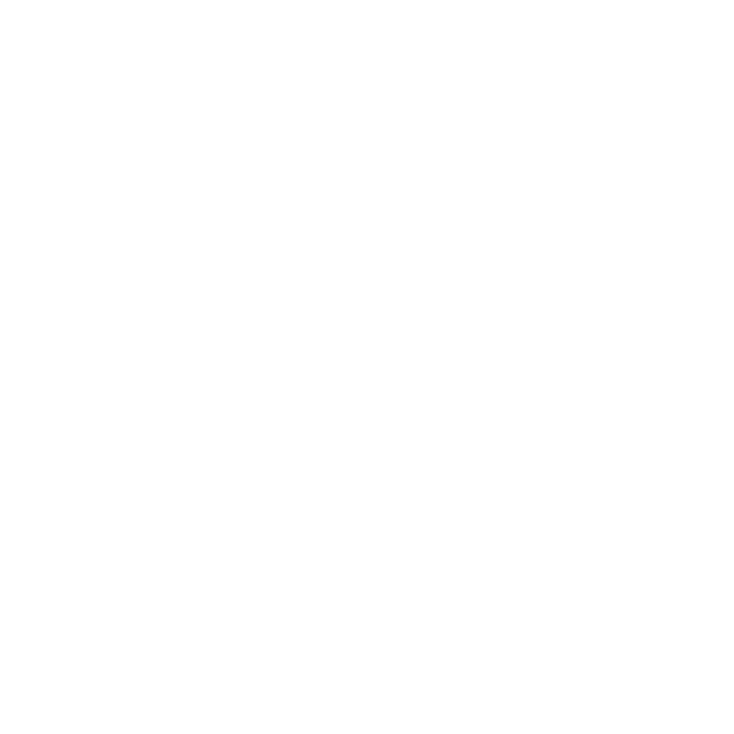

In [118]:
## 1 antecedent and >=2 consequents --------------
a = 1
ante = rules.loc[rules['Number of Antecedents'] == a]
print('Antecedents being bought:', collections.Counter(list(ante['antecedents'])))
l = list(ante['consequents'])
conse = collections.Counter(l)
print('Consequents being bought:', conse)
#display(ante)

## NetworkX graph
fig = plt.figure(figsize = (10, 10))
G = nx.from_pandas_edgelist(ante, 'antecedents', 'consequents')
nx.draw(G, with_labels = True, node_color = 'skyblue', pos = nx.spring_layout(G), node_size = 50)
plt.show()

Antecedents being bought: Counter()
Consequents being bought: Counter()


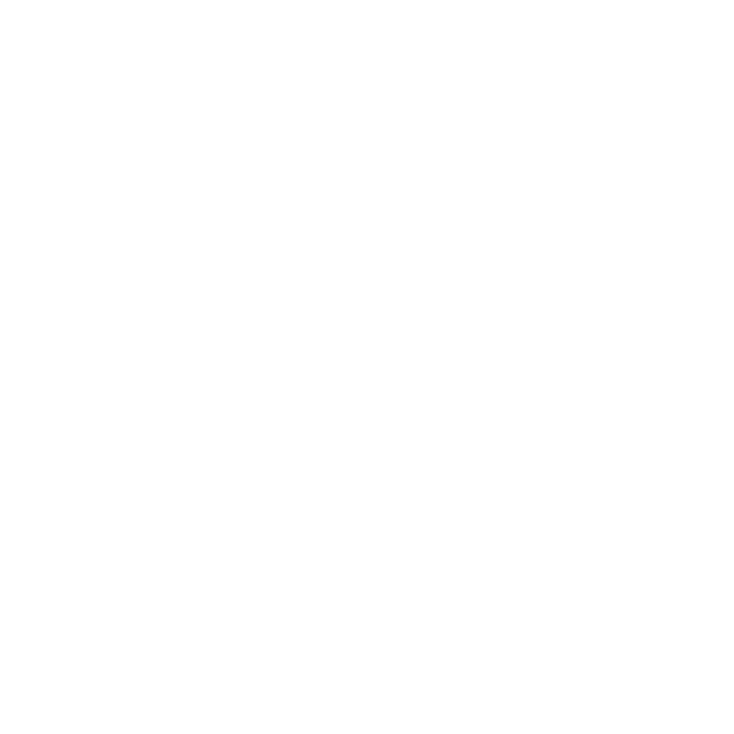

In [112]:
## 2 antecedent and >=2 consequents --------------
a = 2
ante = rules.loc[rules['Number of Antecedents'] == a]
print('Antecedents being bought:', collections.Counter(list(ante['antecedents'])))
l = list(ante['consequents'])
conse = collections.Counter(l)
print('Consequents being bought:', conse)
#display(ante)

## NetworkX graph
fig = plt.figure(figsize = (10, 10))
G = nx.from_pandas_edgelist(ante, 'antecedents', 'consequents')
nx.draw(G, with_labels = True, node_color = 'skyblue', pos = nx.spring_layout(G), node_size = 50)
plt.show()

Antecedents being bought: Counter()
Consequents being bought: Counter()


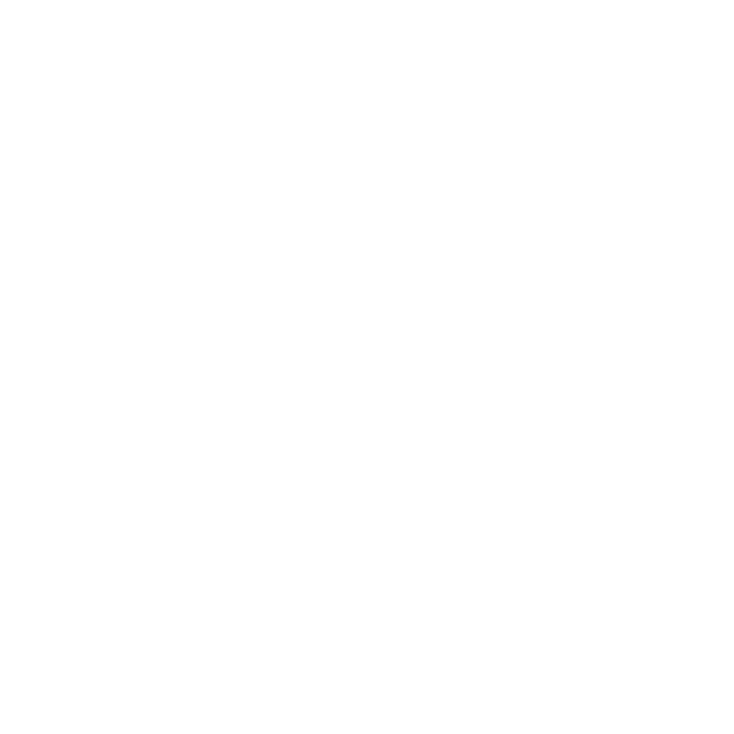

In [113]:
## 3 antecedent and >=2 consequents --------------
a = 3
ante = rules.loc[rules['Number of Antecedents'] == a]
print('Antecedents being bought:', collections.Counter(list(ante['antecedents'])))
l = list(ante['consequents'])
conse = collections.Counter(l)
print('Consequents being bought:', conse)
#display(ante)

## NetworkX graph
fig = plt.figure(figsize = (10, 10))
G = nx.from_pandas_edgelist(ante, 'antecedents', 'consequents')
nx.draw(G, with_labels = True, node_color = 'skyblue', pos = nx.spring_layout(G), node_size = 50)
plt.show()